# Presentation and comparaison of Loss design for PINN in free-field setting

### **Author**: Tancrede Martinez
### **Date**: September 2024  
### This notebook demonstrates the importance of Perfectly Matched Layer (PML) absorbing boundary conditions in 2D wave simulations.
### It especially illustrates it's effectiveness in copupling real and imaginary part in the estimated solution.
### We'll compare:
### 1. **With PML**: Learn both real and imaginary part of outgoing wave u at the same time
### 2. **Without PML**: Struggle to correlate imaginary part when source imaginary value is 0. We also show that sampling scheme have huge impact on performance.


### Note : A non negligeable part of the code is borrowed from https://github.com/vsitzmann/siren/tree/master


## Problem definition

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

In [ ]:
#Define hyperparameters

config = {
  'f' : 1000,
  'L' : 1,                     #Length of domain
  'pml_size' : 0.25,           #Length of pml extension
  'a0' : 1,                    #PML dampling
  'c' : 343,                   #Sound speed in air
}
config['w'] = 2 * np.pi * config['f']
config['pml_boundary'] = config['L'] + config['pml_size']
config['k'] = config['w']/config['c']    #Wavenumber
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)

In [ ]:
#Fonction for derivation and complex number processing

################################################################
# Complex operators
################################################################

def compl_div(x, y):
    """ x / y """
    a = x[..., ::2]
    b = x[..., 1::2]
    c = y[..., ::2]
    d = y[..., 1::2]

    outr = (a * c + b * d) / (c ** 2 + d ** 2)
    outi = (b * c - a * d) / (c ** 2 + d ** 2)
    out = torch.zeros_like(x)
    out[..., ::2] = outr
    out[..., 1::2] = outi
    return out


def compl_mul(x, y):
    """  x * y """
    a = x[..., ::2]
    b = x[..., 1::2]
    c = y[..., ::2]
    d = y[..., 1::2]

    outr = a * c - b * d
    outi = (a + b) * (c + d) - a * c - b * d
    out = torch.zeros_like(x)
    out[..., ::2] = outr
    out[..., 1::2] = outi
    return out

################################################################
#Fonction for gradient computation
################################################################
def gradient(y, x, grad_outputs=None):
    if grad_outputs is None:
        grad_outputs = torch.ones_like(y)
    grad = torch.autograd.grad(y, [x], grad_outputs=grad_outputs, create_graph=True)[0]
    return grad

def jacobian(y, x):
    """ jacobian of y wrt x """
    n_points = y.shape[0]

    jac = torch.zeros(n_points, y.shape[-1], x.shape[-1]).to(y.device) # (n_points, 2, 2)
    for i in range(y.shape[-1]):
        # calculate dydx over batches for each feature value of y
        y_flat = y[...,i].view(-1, 1)
        jac[:, i, :] = torch.autograd.grad(y_flat, x, torch.ones_like(y_flat), create_graph=True)[0]
    return jac


def hessian(y, x):
    """ hessian of y wrt x
    y: shape (N_points, channels)
    x: shape (N_points, 2)
    """
    n_points = y.shape[0]
    grad_y = torch.ones_like(y[..., 0]).to(y.device)
    h = torch.zeros(n_points, y.shape[-1], x.shape[-1], x.shape[-1]).to(y.device)
    for i in range(y.shape[-1]):
        # calculate dydx over batches for each feature value of y
        dydx = torch.autograd.grad(y[..., i], x, grad_y, create_graph=True)[0]

        # calculate hessian on y for each x value
        for j in range(x.shape[-1]):
            h[..., i, j, :] = torch.autograd.grad(dydx[..., j], x, grad_y, create_graph=True)[0][..., :]

    return h

################################################################
#Grid generation
################################################################

def generate_grid(L ,res, device = 'cpu'):
    """
    Create a uniform 2D grid of shape [res², 2] in [-L,L]².
    """
    line = torch.linspace(-L, L, res, device=device)
    X,Y = torch.meshgrid(line, line, indexing='xy')
    grid = torch.stack((X.flatten(), Y.flatten()), dim=-1)

    return grid


## Model definition

In [ ]:
#Model definition SIREN from https://github.com/vsitzmann/siren/tree/master


class SineLayer(nn.Module):
    # See paper sec. 3.2, final paragraph, and supplement Sec. 1.5 for discussion of omega_0.

    # If is_first=True, omega_0 is a frequency factor which simply multiplies the activations before the
    # nonlinearity. Different signals may require different omega_0 in the first layer - this is a
    # hyperparameter.

    # If is_first=False, then the weights will be divided by omega_0 so as to keep the magnitude of
    # activations constant, but boost gradients to the weight matrix (see supplement Sec. 1.5)

    def __init__(self, in_features, out_features, bias=True,
                 is_first=False, omega_0=30):
        super().__init__()
        self.omega_0 = omega_0
        self.is_first = is_first

        self.in_features = in_features
        self.linear = nn.Linear(in_features, out_features, bias=bias)

        self.init_weights()

    def init_weights(self):
        with torch.no_grad():
            if self.is_first:
                self.linear.weight.uniform_(-1 / self.in_features,
                                             1 / self.in_features)
            else:
                self.linear.weight.uniform_(-np.sqrt(6 / self.in_features) / self.omega_0,
                                             np.sqrt(6 / self.in_features) / self.omega_0)

    def forward(self, input):
        return torch.sin(self.omega_0 * self.linear(input))

class Siren(nn.Module):
    def __init__(self, in_features, hidden_features, hidden_layers, out_features, outermost_linear=True,
                 first_omega_0=10., hidden_omega_0=30.):
        super().__init__()

        self.net = []
        self.net.append(SineLayer(in_features, hidden_features,
                                  is_first=True, omega_0=first_omega_0))

        for i in range(hidden_layers):
            self.net.append(SineLayer(hidden_features, hidden_features,
                                      is_first=False, omega_0=hidden_omega_0))

        if outermost_linear:
            final_linear = nn.Linear(hidden_features, out_features)

            with torch.no_grad():
                final_linear.weight.uniform_(-np.sqrt(6 / hidden_features) / hidden_omega_0,
                                              np.sqrt(6 / hidden_features) / hidden_omega_0)

            self.net.append(final_linear)
        else:
            self.net.append(SineLayer(hidden_features, out_features,
                                      is_first=False, omega_0=hidden_omega_0))

        self.net = nn.Sequential(*self.net)

    def forward(self, coords, diff= False):
        coords = coords.clone().detach().requires_grad_(True) # allows to take derivative w.r.t. input
        output = self.net(coords)
        if diff:
            return output, coords
        return output


## Governing equations definition

In [ ]:
def source(coords, sigma = 0.1):
    """
    Computes the gaussian source term of variance sigma:
    The source is centered at (0.,0.)
    """
    dist = torch.linalg.norm(coords, dim = -1)
    source_value = torch.zeros((coords.shape[0],2))
    source_value[..., 0] = torch.exp(-dist**2 / (2 * sigma ** 2))/ (np.sqrt(2 * np.pi) * sigma)
    return source_value.to(device)

def wave_equation(u, coords):
    """
    Computes the frequency-domain wave equation residual:
    ∇²u + k²u = source
    where u is complex: [..., 2] = (real, imag)
    """
    hess = hessian(u, coords)  # shape: (N, 2, 2, 2)

    # Laplacian = trace of the Hessian
    laplace_u_real = hess[..., 0, 0, 0] + hess[..., 0, 1, 1]
    laplace_u_imag = hess[..., 1, 0, 0] + hess[..., 1, 1, 1]

    # Helmholtz equation: ∇²u + k²u = s (applied to both real and imag)
    source_value = source(coords)
    residual_real = laplace_u_real + (config['k'] ** 2) * u[..., 0] + source_value[..., 0]
    residual_imag = laplace_u_imag + (config['k'] ** 2) * u[..., 1] + source_value[..., 1]

    residual = torch.stack([residual_real, residual_imag], dim=-1)

    return residual


def pml_wave_equation(u, coords):
    """
    Computes the frequency-domain Perfectly Matched Layer (PML) Wave Equation residual :
    ∇S^-1 R ∇u + k²det(S)u = det(S)source
    where u is complex: [..., 2] = (real, imag)
    """
    du = jacobian(u, coords)
    dudx = du[..., 0]
    dudy = du[..., 1]

    squared_slowness = torch.ones_like(coords)    #corresponds to wave celerity modification e.g slow = 1 + 0j in our case
    squared_slowness[..., 1] = 0.
    dist_west = -torch.clamp(coords[..., 0] + config['pml_size'], max=0)
    dist_east = torch.clamp(coords[..., 0] - config['pml_size'], min=0)
    dist_south = -torch.clamp(coords[..., 1] + config['pml_size'], max=0)
    dist_north = torch.clamp(coords[..., 1] - config['pml_size'], min=0)

    sx = config['w'] * config['a0'] * ((dist_west / config['L']) ** 2 + (dist_east / config['L']) ** 2)[..., None]
    sy = config['w'] * config['a0'] * ((dist_north / config['L']) ** 2 + (dist_south / config['L']) ** 2)[..., None]

    ex = torch.cat((torch.ones_like(sx), - sx / config['w']), dim=-1)
    ey = torch.cat((torch.ones_like(sy), - sy / config['w']), dim=-1)

    Ax = compl_div(ey, ex).repeat(1, dudx.shape[-1] // 2)
    Ay = compl_div(ex, ey).repeat(1, dudx.shape[-1] // 2)
    S = compl_mul(ex, ey).repeat(1, dudx.shape[-1] // 2)

    ax = jacobian(compl_mul(Ax, dudx), coords)
    ay = jacobian(compl_mul(Ay, dudy), coords)

    ax = ax[..., 0]
    ay = ay[..., 1]

    s = compl_mul(compl_mul(S, squared_slowness), config['k'] ** 2 * u + source(coords))

    residual = ax + ay + s

    return residual


## Trainer definition

In [ ]:
class WaveTrainer:
    """
    Train a model to solve the wave equation given a gaussian source centered at (0., 0.) for
    an acoustical setup described by config.
    The WaveTrainer as two mode:
      use_pml = True -> Solve the wave equation using PML description.
      use_pml = False -> Solve the wave equation using Sommerfeld condition as exterior boundary condition.
    """
    def __init__(self, model, optimizer, wave_equation, loss_fn, config):
        self.model = model
        self.optimizer = optimizer
        self.loss_fn = loss_fn
        self.config = config
        self.device = device
        self.L = config['L']
        self.res = 64
        self.Lpml = config['pml_size']

        # Check if PML is being used
        self.use_pml = 'pml' in wave_equation.__name__.lower()
        self.sampling_type = 'square'
        # if self.use_pml:
        #     self.pml_boundary = self.L + self.Lpml  # Take account pml layer
        # else:
        #     self.pml_boundary = self.L
        self.pml_boundary = self.L + self.Lpml  # We use this boundary even for Sommerfeld as we will compute Sommerfeld condition in this area
        self.f = config['f']
        self.w = config['w']
        self.k = config['k']    # Define point source at origin
        self.source_coords = torch.tensor([[0.0, 0.0]], requires_grad=True, device = device)
        self.source_values = torch.tensor([[1.0, 0.0]], device = device)  # Real source
        self.wave_residual = wave_equation

        self.train_params = config['train_params']
        self.losses = {
            'total' : [],
            'pde_real' : [],
            'pde_imag' : [],
            'sommerfeld': [],
        }

        self.coords_grid = generate_grid(self.L, self.res, device = self.device)

    def sommerfeld_boundary_loss(self):
        """
        Implement Sommerfeld radiation condition: ∂u/∂r - iku = 0 at boundary
        For 2D: lim_{r→∞} √r (∂u/∂r - iku) = 0
        """
        # Here we use a circular boundary that is why we compute the field on a domain greater than [-L,L]² (circular boundary shows better results than rectangular one)
        radius = self.L * np.sqrt(2)

        if self.use_pml:
            return torch.tensor(0.0, device=self.device)  # No Sommerfeld needed with PML

        # Sample points on the boundary (circle of radius L)
        n_boundary_pts = 256
        theta = torch.linspace(0, 2*np.pi, n_boundary_pts, device=self.device) + 0.1 * torch.randn(n_boundary_pts, device=self.device)
        x_boundary = radius * torch.cos(theta)
        y_boundary = radius * torch.sin(theta)
        boundary_coords = torch.stack([x_boundary, y_boundary], dim=1)
        boundary_coords.requires_grad_(True)

        # Get solution and derivatives at boundary
        u, coords = self.model(boundary_coords, diff=True)

        # Compute radial derivative ∂u/∂r
        # For complex field u = u_real + i*u_imag
        u_real = u[:, 0]
        u_imag = u[:, 1]

        # Get spatial derivatives
        du = jacobian(u, coords)

        u_real_x = du[:, 0, 0]
        u_real_y = du[:, 1, 0]
        u_imag_x = du[:, 0, 1]
        u_imag_y = du[:, 1, 1]

        # Radial derivatives: ∂u/∂r = (x*∂u/∂x + y*∂u/∂y)/r
        du_real_dr = (x_boundary * u_real_x + y_boundary * u_real_y) / radius
        du_imag_dr = (x_boundary * u_imag_x + y_boundary * u_imag_y) / radius

        # Sommerfeld condition: ∂u/∂r - iku = 0
        # For u = u_real + i*u_imag: ∂u/∂r - ik(u_real + i*u_imag) = 0
        # Real part: ∂u_real/∂r + k*u_imag = 0
        # Imag part: ∂u_imag/∂r - k*u_real = 0

        sommerfeld_real = du_real_dr + self.k * u_imag
        sommerfeld_imag = du_imag_dr - self.k * u_real

        loss_real = (sommerfeld_real**2).mean()
        loss_imag = (sommerfeld_imag**2).mean()

        return loss_real + loss_imag

    def train(self):
        n_scheduler = self.train_params['Adam']['epochs'] // 2
        scheduler = torch.optim.lr_scheduler.MultiStepLR(self.optimizer,milestones=[n_scheduler*(i+1) for i in range(1)],gamma=0.5,)
        self.model.train()

        # Adam training phase
        for epoch in range(self.train_params['Adam']['epochs']):
            self.model.train()
            if epoch % self.train_params['Adam']['keeping_time'] == 0:
                if self.sampling_type == 'circle':  # Sample using a circular scheme of increasing radius through epochs

                  theta = 2 * np.pi * torch.rand(self.train_params['Adam']['batch_size'], device=self.device)
                  r_min, r_max = 0.0, np.sqrt(2) * self.L * epoch/self.train_params['Adam']['epochs'] + 0.02     # Use custom size this time to be exactly Sommerfeld boundary
                  r = r_min + (r_max - r_min) * torch.rand(self.train_params['Adam']['batch_size'], device=self.device)
                  x_sample = r * torch.cos(theta)
                  y_sample = r * torch.sin(theta)
                  coords_sample = torch.stack((x_sample, y_sample), dim = 1)

                else:                             # Sample using a uniform domain scheme.

                    x_sample = 2*(torch.rand(self.train_params['Adam']['epochs'], device=self.device)-0.5) * self.pml_boundary + self.source_coords[0,0]
                    y_sample = 2*(torch.rand(self.train_params['Adam']['epochs'], device=self.device)-0.5) * self.pml_boundary + self.source_coords[0,1]
                    coords_sample = torch.stack((x_sample, y_sample), dim = 1)

            u, coords = self.model(coords_sample, diff = True)
            pml_constraint = self.wave_residual(u, coords)
            loss_pde_real =  torch.abs(pml_constraint[:,0]**2).mean()
            loss_pde_imag =  torch.abs(pml_constraint[:,1]**2).mean()
            loss_sommerfeld = self.sommerfeld_boundary_loss()

            loss = loss_pde_real + loss_pde_imag + 10 * loss_sommerfeld
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            scheduler.step()

            # Store losses
            self.losses['total'].append(loss.item())
            self.losses['pde_real'].append(loss_pde_real.item())
            self.losses['pde_imag'].append(loss_pde_imag.item())
            self.losses['sommerfeld'].append(loss_sommerfeld.item())
            #scheduler.step()

            # Print progress
            if epoch % 250 == 0:
              if self.use_pml:
                print(f"Epoch {epoch:4d}: Total Loss = {loss.item():.6e}, "
                      f"PDE Real = {loss_pde_real.item():.6e}, "
                      f"PDE Imag = {loss_pde_imag.item():.6e}, "
                )
              else:
                print(f"Epoch {epoch:4d}: Total Loss = {loss.item():.6e}, "
                      f"PDE Real = {loss_pde_real.item():.6e}, "
                      f"PDE Imag = {loss_pde_imag.item():.6e}, "
                      f"Sommerfeld = {loss_sommerfeld.item():.6e} "
                      )
            if epoch % 1000 == 0:
                self.plot()

        # L-BFGS training phase
        # Optimizer definition
        optimizer = torch.optim.LBFGS(self.model.parameters(),  lr=0.05,
            max_iter = 25,
            line_search_fn='strong_wolfe')

        # Criterion definition
        def criterion(coords_sample):
            u, coords = self.model(coords_sample, diff = True)
            pml_constraint = self.wave_residual(u, coords)
            loss_pde_real =  torch.abs(pml_constraint[:,0]**2).mean()
            loss_pde_imag =  torch.abs(pml_constraint[:,1]**2).mean()
            loss_sommerfeld = self.sommerfeld_boundary_loss()
            loss = loss_pde_real + loss_pde_imag + 10 * loss_sommerfeld
            return loss

        def make_closure(coords_sample):
            def closure():
                optimizer.zero_grad()
                loss = criterion(coords_sample)
                loss.backward()
                return loss
            return closure

        for epoch in range(self.train_params['LBFGS']['epochs']):
            if epoch % self.train_params['LBFGS']['keeping_time']  == 0:
                x_sample = 2*(torch.rand(self.train_params['LBFGS']['batch_size'], device=self.device)-0.5) * self.pml_boundary + self.source_coords[0,0]
                y_sample = 2*(torch.rand(self.train_params['LBFGS']['batch_size'], device=self.device)-0.5) * self.pml_boundary + self.source_coords[0,1]

                coords_sample = torch.stack((x_sample, y_sample), dim = 1)
                closure = make_closure(coords_sample)
            loss = optimizer.step(closure)

            # Loss values computation (for plotting only)
            # Validation loss computation (consistent across epochs)
            self.model.eval()

            # Create a fresh copy of validation coords with gradients enabled
            coords_val_fresh = coords_sample.clone().detach().requires_grad_(True)

            # Compute validation losses (gradients needed for wave_residual)
            u_val, coords_val_grad = self.model(coords_val_fresh, diff=True)

            pml_constraint_val = self.wave_residual(u_val, coords_val_grad)
            loss_pde_real_val = torch.abs(pml_constraint_val[:,0]**2).mean()
            loss_pde_imag_val = torch.abs(pml_constraint_val[:,1]**2).mean()

            # These losses also need gradients for their internal computations
            loss_sommerfeld_val = self.sommerfeld_boundary_loss()

            total_val_loss = loss_pde_real_val + loss_pde_imag_val + loss_sommerfeld_val

            # Store validation losses
            self.losses['total'].append(total_val_loss.item())
            self.losses['pde_real'].append(loss_pde_real_val.item())
            self.losses['pde_imag'].append(loss_pde_imag_val.item())
            self.losses['sommerfeld'].append(loss_sommerfeld_val.item())

            self.model.train()  # Back to training mode

            # Print progress
            if epoch % 10 == 0:
                print(f"Epoch {epoch:4d}: Total Loss = {loss.item():.6e}, ")
            if epoch % 20 == 0:
                self.plot()
        self.plot_losses()

    def plot(self):
        """Plot current estimated pressure field."""
        with torch.no_grad():
          u = self.model(self.coords_grid).cpu().numpy()
          u_real = u[..., 0].reshape(self.res, self.res)
          u_imag = u[..., 1].reshape(self.res, self.res)
        # Create the figure and subplots
        fig, axs = plt.subplots(1, 2, figsize=(12, 5))

        # Real part plot
        im0 = axs[0].imshow(u_real, extent=[-self.L, self.L, -self.L, self.L], origin='lower', cmap='turbo')
        axs[0].set_title('Real part of u')
        fig.colorbar(im0, ax=axs[0])

        # Imaginary part plot
        im1 = axs[1].imshow(u_imag, extent=[-self.L, self.L, -self.L, self.L], origin='lower', cmap='turbo')
        axs[1].set_title('Imag part of u')
        fig.colorbar(im1, ax=axs[1])

        plt.tight_layout()

        plt.show()

    def plot_losses(self):
      """Plot training losses over epochs."""
      epochs = range(len(self.losses['total']))
      fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 10))

      # Total loss
      ax1.semilogy(epochs, self.losses['total'], 'b-', linewidth=2)
      ax1.set_title('Total Loss')
      ax1.set_xlabel('Epoch')
      ax1.set_ylabel('Loss')
      ax1.grid(True, alpha=0.3)

      # PDE real loss
      ax2.semilogy(epochs, self.losses['pde_real'], 'r-', linewidth=2)
      ax2.set_title('PDE Real Loss')
      ax2.set_xlabel('Epoch')
      ax2.set_ylabel('Loss')
      ax2.grid(True, alpha=0.3)

      # PDE imaginary loss
      ax3.semilogy(epochs, self.losses['pde_imag'], 'g-', linewidth=2)
      ax3.set_title('PDE Imaginary Loss')
      ax3.set_xlabel('Epoch')
      ax3.set_ylabel('Loss')
      ax3.grid(True, alpha=0.3)

      # Sommerfeld loss
      ax3.semilogy(epochs, self.losses['sommerfeld'], 'g-', linewidth=2)
      ax3.set_title('Sommerfeld Loss')
      ax3.set_xlabel('Epoch')
      ax3.set_ylabel('Loss')
      ax3.grid(True, alpha=0.3)

      plt.tight_layout()
      plt.show()

      # Combined plot
      plt.figure(figsize=(10, 6))
      plt.semilogy(epochs, self.losses['total'], 'b-', label='Total Loss', linewidth=2)
      plt.semilogy(epochs, self.losses['pde_real'], 'r--', label='PDE Real', alpha=0.7)
      plt.semilogy(epochs, self.losses['pde_imag'], 'g--', label='PDE Imaginary', alpha=0.7)

      plt.xlabel('Epoch')
      plt.ylabel('Loss')
      plt.title('Training Loss Components')
      plt.legend()
      plt.grid(True, alpha=0.3)
      plt.tight_layout()
      plt.show()


## Training configuration

In [ ]:
#Network hyper parameters
in_features = 2
hidden_features = 64
hidden_layers = 4
out_features = 2
lr = 1e-4

config['train_params'] = {
    'Adam' : {
      'batch_size' : 8192,
      'epochs' : 5000,
      'keeping_time' : 25, #Number of epochs using the same batch
    },
    'LBFGS' : {
      'batch_size' : 8192 * 4,
      'epochs' : 100,
      'keeping_time' : 3, #Number of epochs using the same batch
    }
}


## Source visualization

(10000, 2)


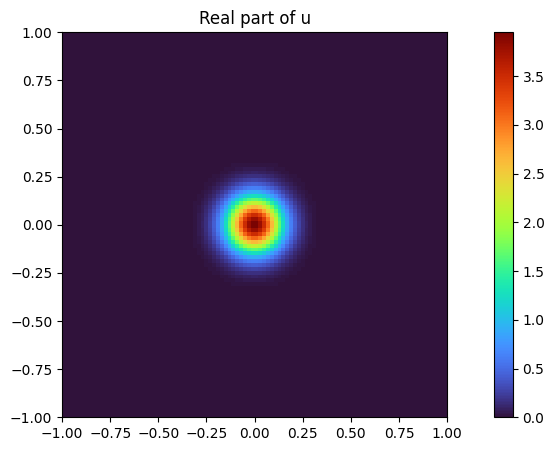

In [ ]:
n = 100
# 1D coordinate vector
x = np.linspace(-config['L'], config['L'], n)
y = np.linspace(-config['L'], config['L'], n)

# Create 2D grid
X, Y = np.meshgrid(x, y)

# Optional: stack into a (N, 2) array if you want coordinate pairs
grid = np.stack([X.flatten(), Y.flatten()], axis=-1)
grid = torch.tensor(grid, device = device)
source_value = source(grid).cpu().numpy()
print(source_value.shape)
source_value = source_value[...,0]

# Reshape to 2D
source_value = source_value.reshape(n, n)

# Plot
fig, ax = plt.subplots(1, 1, figsize=(12, 5))
im = ax.imshow(source_value, extent=[-config['L'], config['L'], -config['L'], config['L']],
               origin='lower', cmap='turbo')
ax.set_title('Real part of u')
fig.colorbar(im, ax=ax)
plt.show()


# Mathematical model comparison

### Source modelisation
In the following experiment, since point source model with dirac function are hard to model, we use instead a gaussian point source located at $(x_s,y_s)$ defined by :

$$ u_s(x,y) = \frac { \text{exp}(- \frac 1 2 \frac {(x-x_s)^2 + (y-y_s)^2} {\sigma ^2}) } {\sigma \sqrt{2 \pi}}$$

### PML Based Implementation :
Loss definition :

$$\mathcal{L}(\theta) = \mathcal{L}_{\text{pml}}(\theta) $$

$$\mathcal{L}_{\text{pml}}(\theta) = \sum_{x,y \in \text{Batch}}|\frac {\partial } {\partial x}(\frac {s_y} {s_x}\frac {\partial \Phi _{\theta}} {\partial x})(x,y) + \frac {\partial } {\partial y}(\frac {s_x} {s_y}\frac {\partial \Phi _{\theta}} {\partial y})(x,y) + k^2 s_x s_y \phi _{\theta}(x,y) - s_x s_y u_s(x,y)|^2 $$
With :

$ s_x = 1 - j\frac {\sigma_x} {\omega}$

$ \sigma_x = \begin{cases}
 a_0\omega(\frac {l_x} {L_{PML}})^2 & \text{if } x \in \Omega _{\text{PML-Boundary}} \\
0 & \text{otherwise}
\end{cases} $

Epoch    0: Total Loss = 3.314523e+03, PDE Real = 2.706139e+03, PDE Imag = 6.083839e+02, 


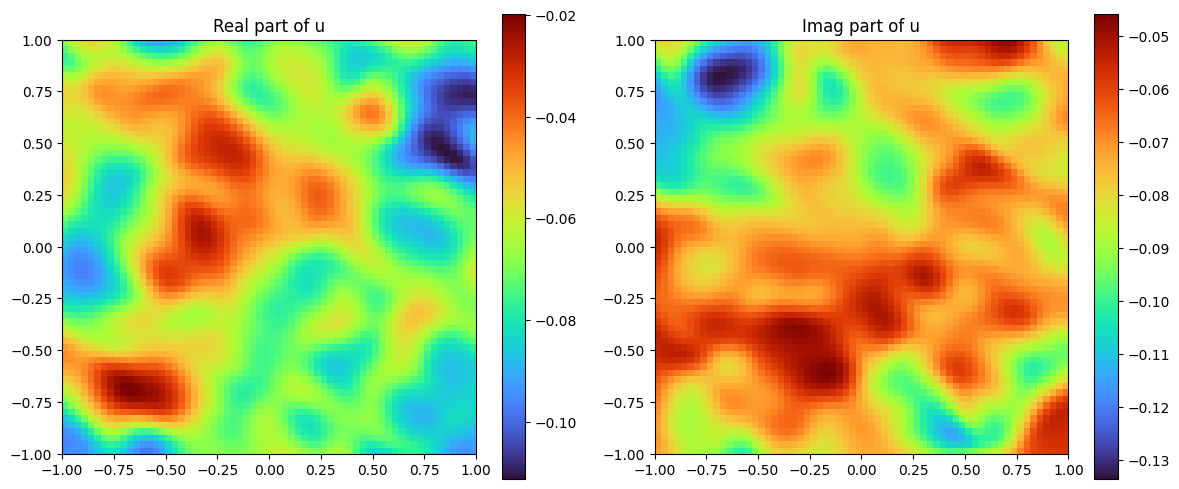

Epoch  250: Total Loss = 2.756800e-01, PDE Real = 1.284786e-01, PDE Imag = 1.472014e-01, 
Epoch  500: Total Loss = 1.146289e-01, PDE Real = 5.611921e-02, PDE Imag = 5.850968e-02, 
Epoch  750: Total Loss = 6.019453e-02, PDE Real = 3.096041e-02, PDE Imag = 2.923412e-02, 
Epoch 1000: Total Loss = 3.806404e-02, PDE Real = 1.957048e-02, PDE Imag = 1.849356e-02, 


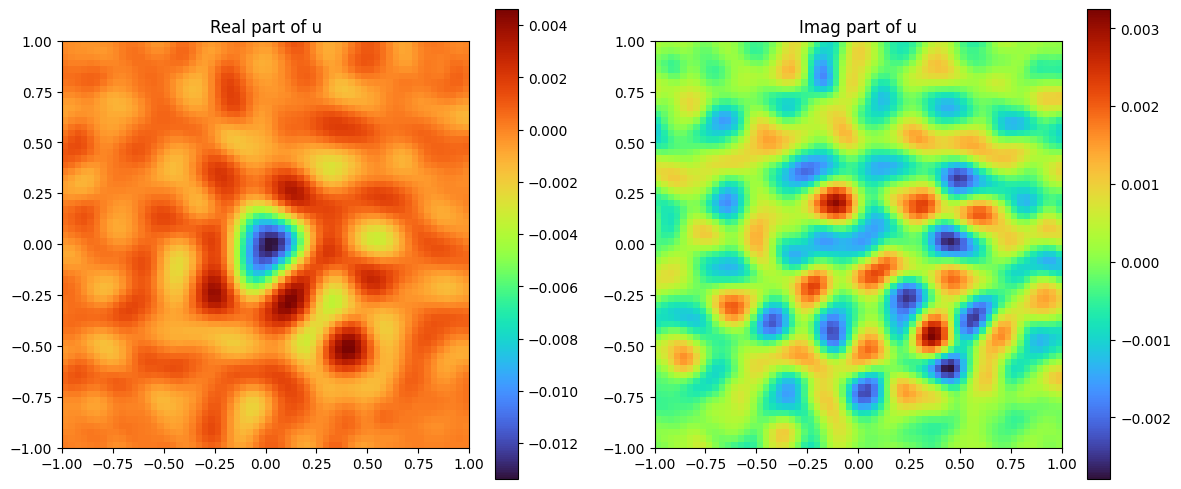

Epoch 1250: Total Loss = 2.707287e-02, PDE Real = 1.409479e-02, PDE Imag = 1.297808e-02, 
Epoch 1500: Total Loss = 2.081738e-02, PDE Real = 1.167749e-02, PDE Imag = 9.139893e-03, 
Epoch 1750: Total Loss = 1.606905e-02, PDE Real = 8.862876e-03, PDE Imag = 7.206169e-03, 
Epoch 2000: Total Loss = 1.376237e-02, PDE Real = 7.983901e-03, PDE Imag = 5.778472e-03, 


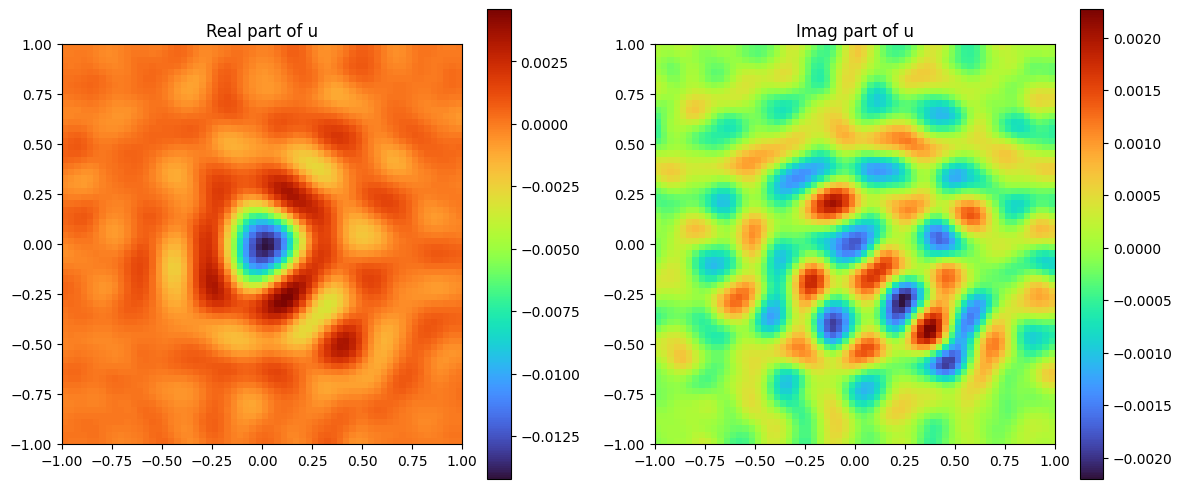

Epoch 2250: Total Loss = 1.064016e-02, PDE Real = 6.237142e-03, PDE Imag = 4.403014e-03, 
Epoch 2500: Total Loss = 8.996796e-03, PDE Real = 5.224880e-03, PDE Imag = 3.771915e-03, 
Epoch 2750: Total Loss = 8.707079e-03, PDE Real = 5.411646e-03, PDE Imag = 3.295433e-03, 
Epoch 3000: Total Loss = 7.888873e-03, PDE Real = 4.821423e-03, PDE Imag = 3.067450e-03, 


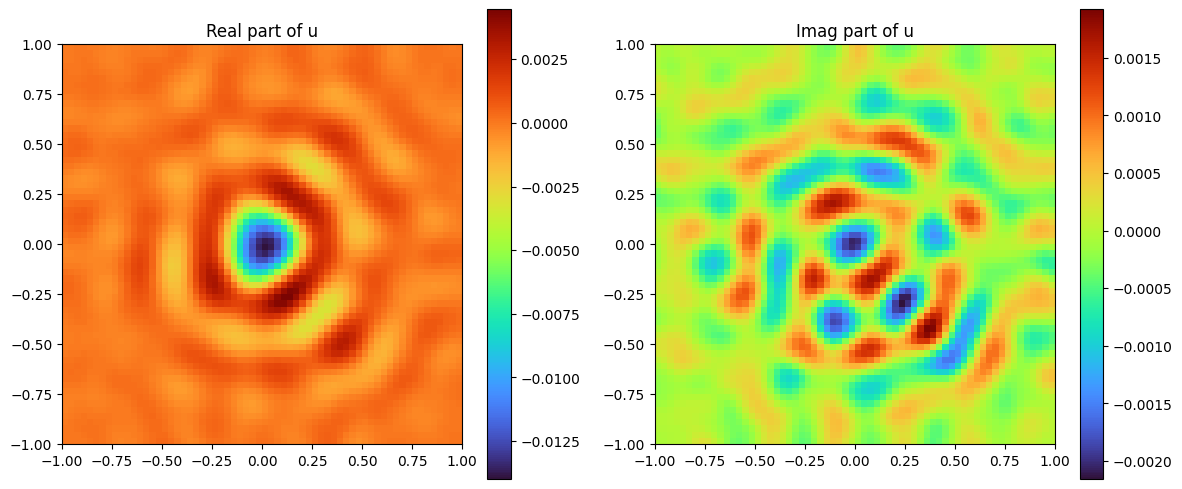

Epoch 3250: Total Loss = 7.170703e-03, PDE Real = 4.294896e-03, PDE Imag = 2.875807e-03, 
Epoch 3500: Total Loss = 6.491796e-03, PDE Real = 3.949142e-03, PDE Imag = 2.542655e-03, 
Epoch 3750: Total Loss = 6.451879e-03, PDE Real = 4.002338e-03, PDE Imag = 2.449541e-03, 
Epoch 4000: Total Loss = 5.687173e-03, PDE Real = 3.562200e-03, PDE Imag = 2.124973e-03, 


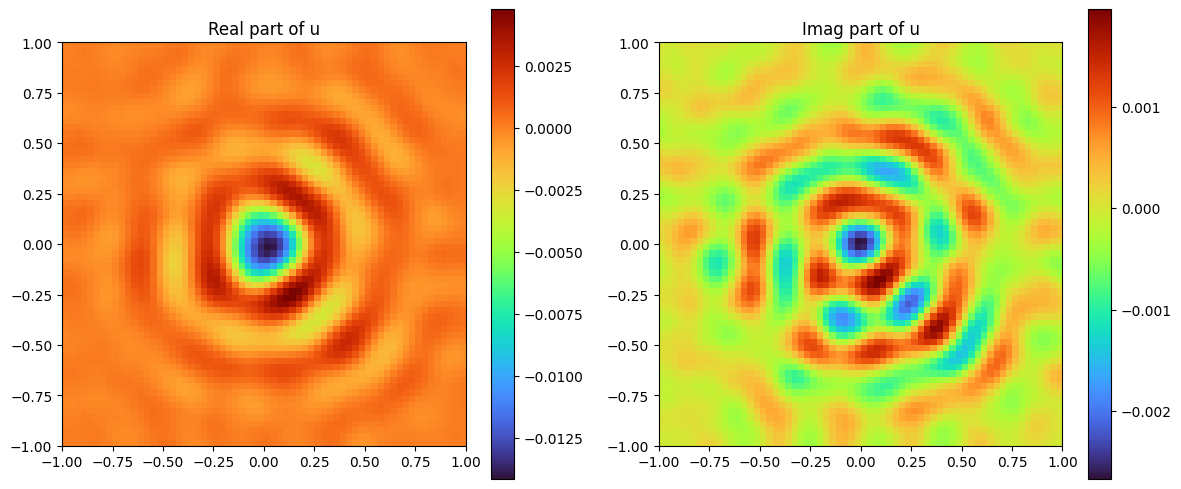

Epoch 4250: Total Loss = 5.251198e-03, PDE Real = 3.313108e-03, PDE Imag = 1.938089e-03, 
Epoch 4500: Total Loss = 4.572413e-03, PDE Real = 2.926686e-03, PDE Imag = 1.645727e-03, 
Epoch 4750: Total Loss = 5.585321e-03, PDE Real = 2.890847e-03, PDE Imag = 2.694474e-03, 
Epoch    0: Total Loss = 4.403755e-03, 


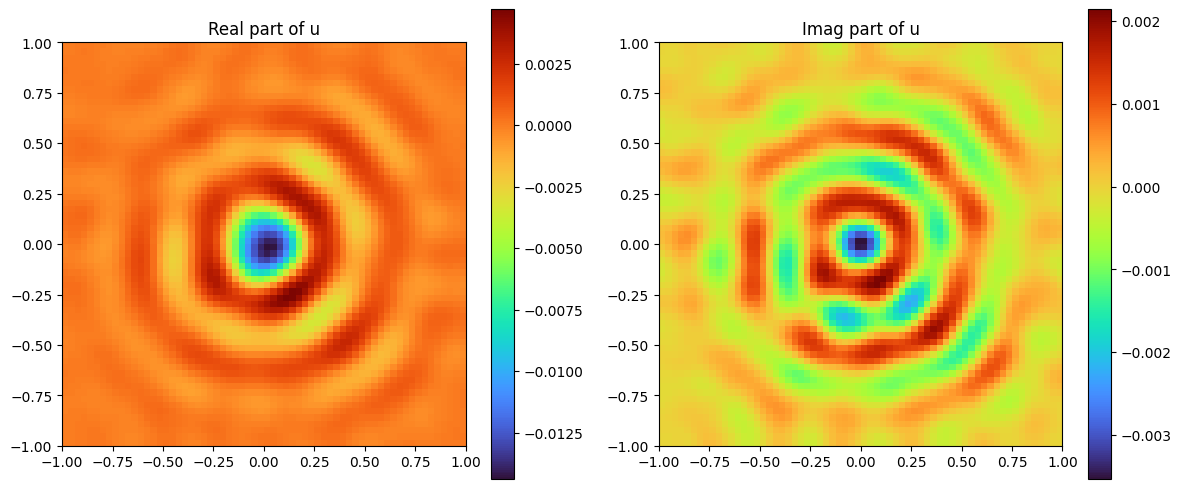

Epoch   10: Total Loss = 2.234798e-03, 
Epoch   20: Total Loss = 1.118181e-03, 


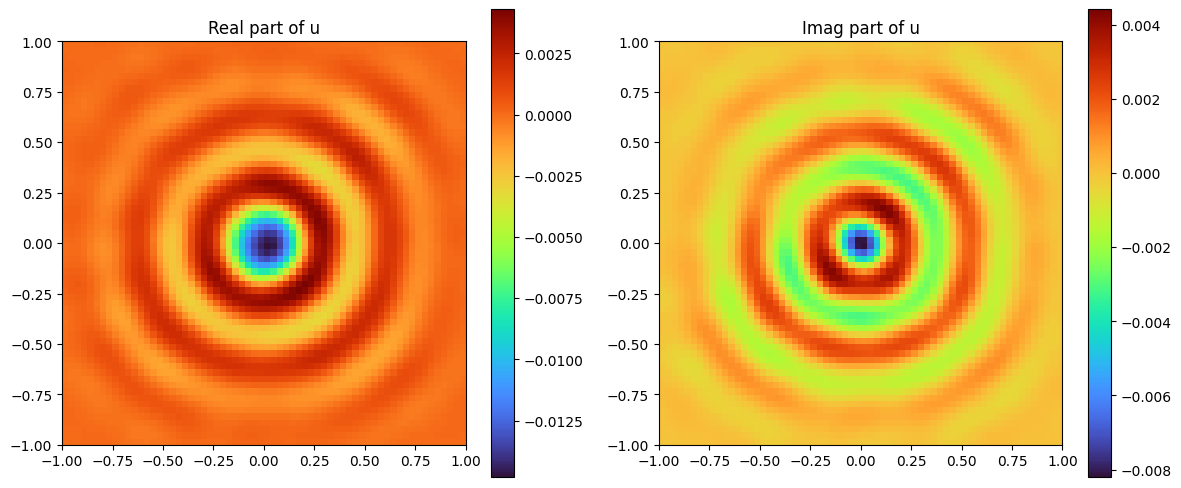

Epoch   30: Total Loss = 7.111103e-04, 
Epoch   40: Total Loss = 4.494514e-04, 


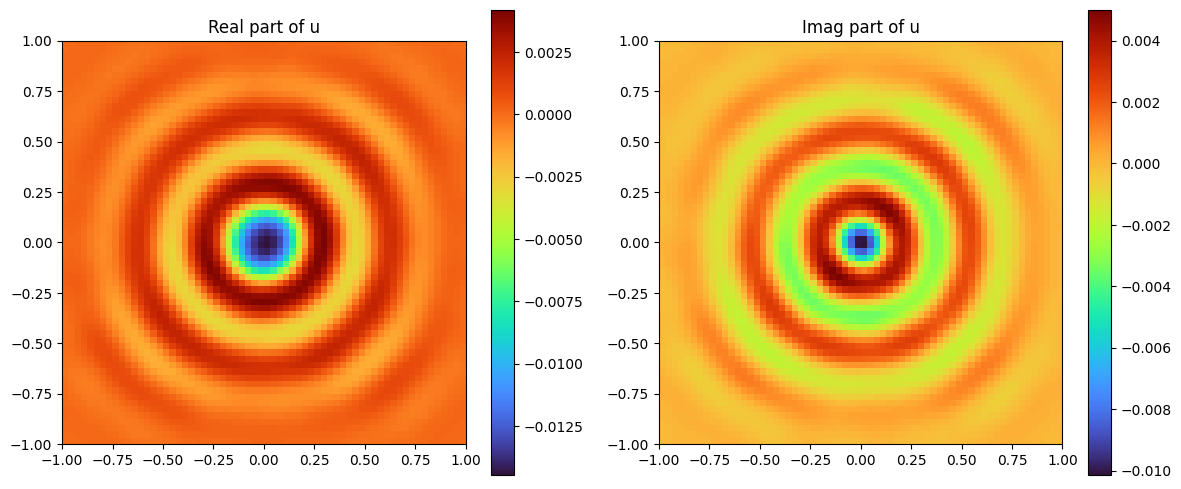

Epoch   50: Total Loss = 2.911651e-04, 
Epoch   60: Total Loss = 1.968327e-04, 


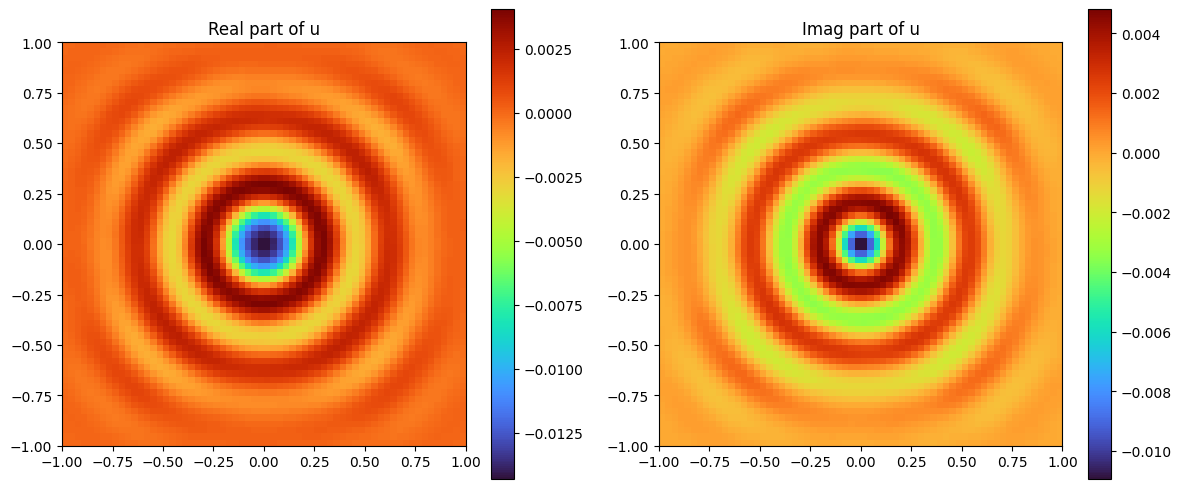

Epoch   70: Total Loss = 1.385554e-04, 
Epoch   80: Total Loss = 1.060872e-04, 


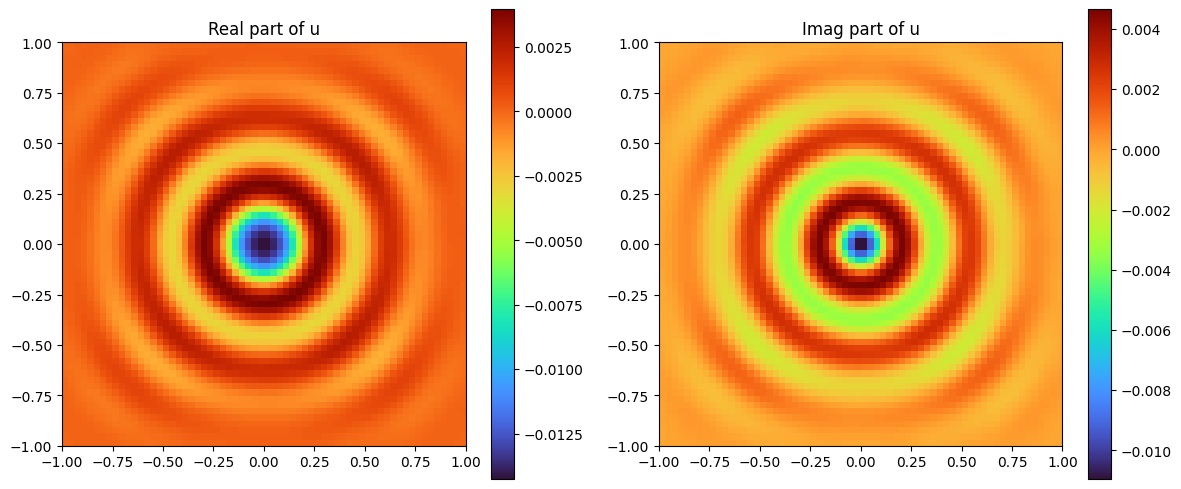

Epoch   90: Total Loss = 8.673784e-05, 


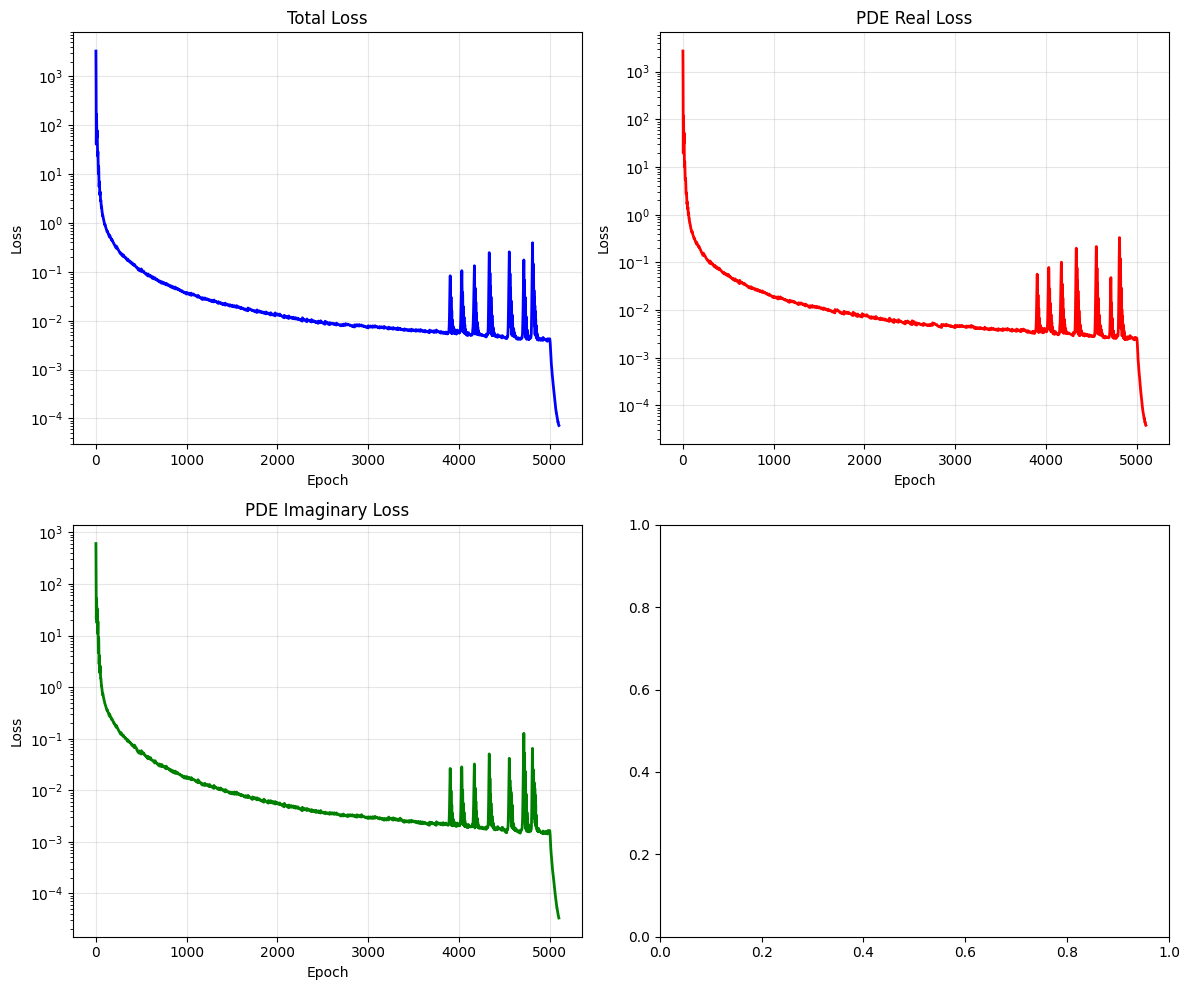

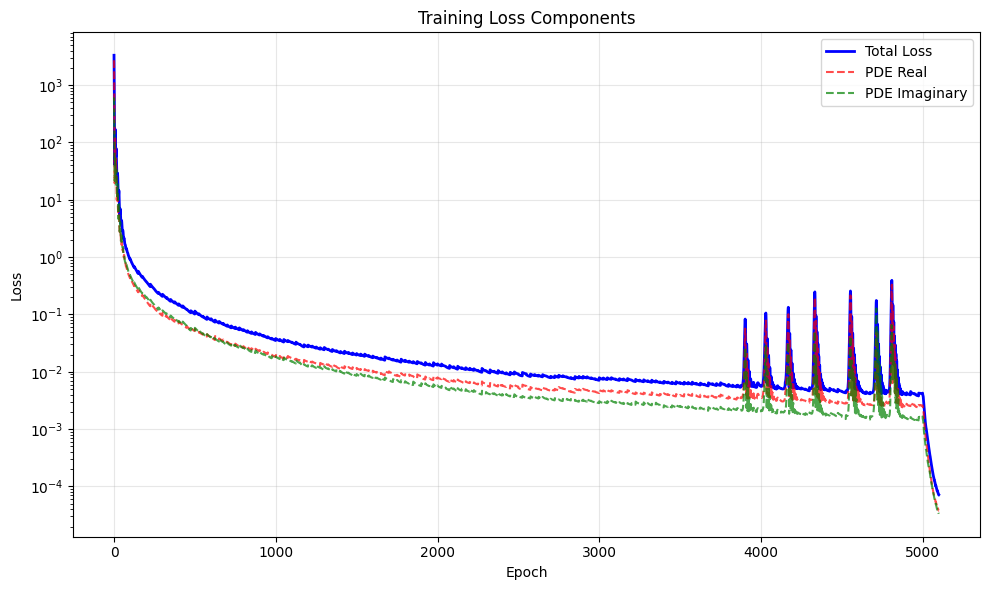

In [ ]:
#Using PML based Wave Equation

model = Siren(in_features = in_features, hidden_features = hidden_features, hidden_layers = hidden_layers, out_features = out_features).to(device)
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = lr)
trainer = WaveTrainer(model, optimizer, pml_wave_equation, loss_fn, config)
trainer.train()

# We observe a coherent field correlating real and imaginary part

### Sommerfeld based Implementation :
Loss definition :

$$\mathcal{L}(x) = \mathcal{L}_{\text{wave}}(x) + \lambda_{\text{sommerfeld}} \mathcal{L}_{\text{sommerfeld}}(x)$$

$$\mathcal{L}_{\text{wave}}(x) = |\Delta \Phi _{\theta}(x) + k^2 \Phi _{\theta}(x) - u_s(x)|^2 $$
$$ \mathcal{L}_{\text{sommerfeld}}(x) = r^2|\frac{\partial \Phi _{\theta}}{\partial r}(x) - j k \Phi_{\theta}(x)|²$$

Epoch    0: Total Loss = 9.477143e+01, PDE Real = 1.983699e+01, PDE Imag = 7.182529e+01, Sommerfeld = 3.109157e-01 


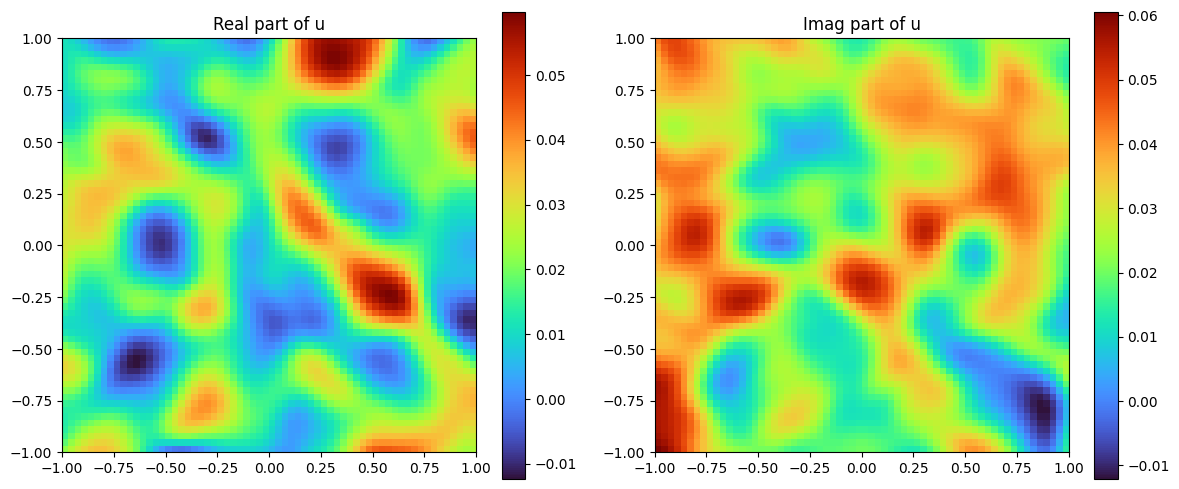

Epoch  250: Total Loss = 8.821637e-02, PDE Real = 4.687301e-02, PDE Imag = 3.647371e-02, Sommerfeld = 4.869659e-04 
Epoch  500: Total Loss = 3.247896e-02, PDE Real = 1.822292e-02, PDE Imag = 1.273781e-02, Sommerfeld = 1.518234e-04 
Epoch  750: Total Loss = 1.858085e-02, PDE Real = 1.100554e-02, PDE Imag = 6.813206e-03, Sommerfeld = 7.621071e-05 
Epoch 1000: Total Loss = 1.246578e-02, PDE Real = 7.821710e-03, PDE Imag = 4.223537e-03, Sommerfeld = 4.205309e-05 


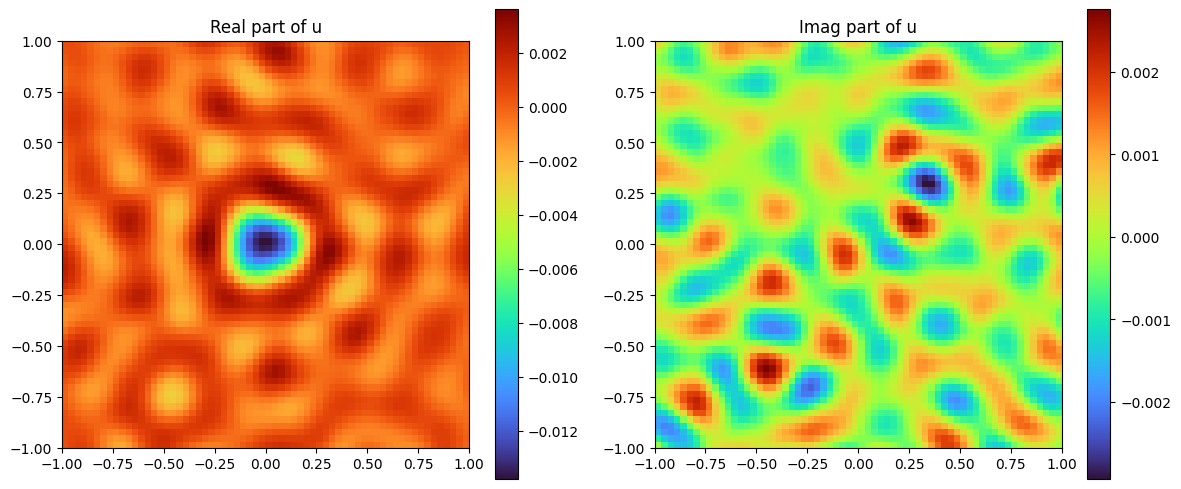

Epoch 1250: Total Loss = 8.670039e-03, PDE Real = 5.329544e-03, PDE Imag = 3.005189e-03, Sommerfeld = 3.353062e-05 
Epoch 1500: Total Loss = 6.771313e-03, PDE Real = 4.407026e-03, PDE Imag = 2.143246e-03, Sommerfeld = 2.210401e-05 
Epoch 1750: Total Loss = 5.667392e-03, PDE Real = 3.703861e-03, PDE Imag = 1.743814e-03, Sommerfeld = 2.197171e-05 
Epoch 2000: Total Loss = 5.422276e-03, PDE Real = 3.525026e-03, PDE Imag = 1.693549e-03, Sommerfeld = 2.037017e-05 


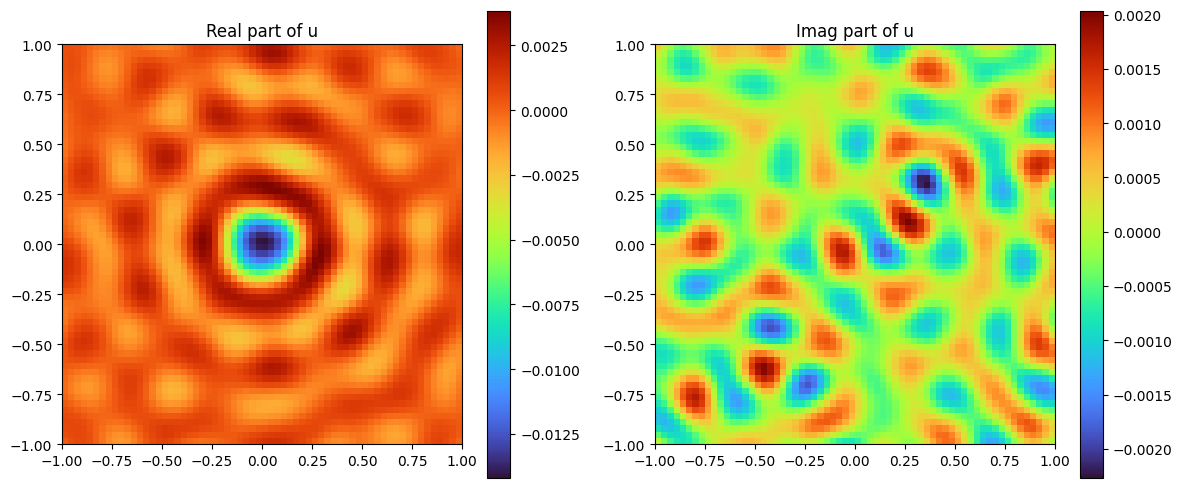

Epoch 2250: Total Loss = 5.022470e-03, PDE Real = 3.251821e-03, PDE Imag = 1.543101e-03, Sommerfeld = 2.275476e-05 
Epoch 2500: Total Loss = 2.850621e-02, PDE Real = 2.216838e-02, PDE Imag = 4.888095e-03, Sommerfeld = 1.449732e-04 
Epoch 2750: Total Loss = 3.808967e-03, PDE Real = 2.467908e-03, PDE Imag = 1.208591e-03, Sommerfeld = 1.324682e-05 
Epoch 3000: Total Loss = 3.301939e-03, PDE Real = 2.242249e-03, PDE Imag = 9.426129e-04, Sommerfeld = 1.170775e-05 


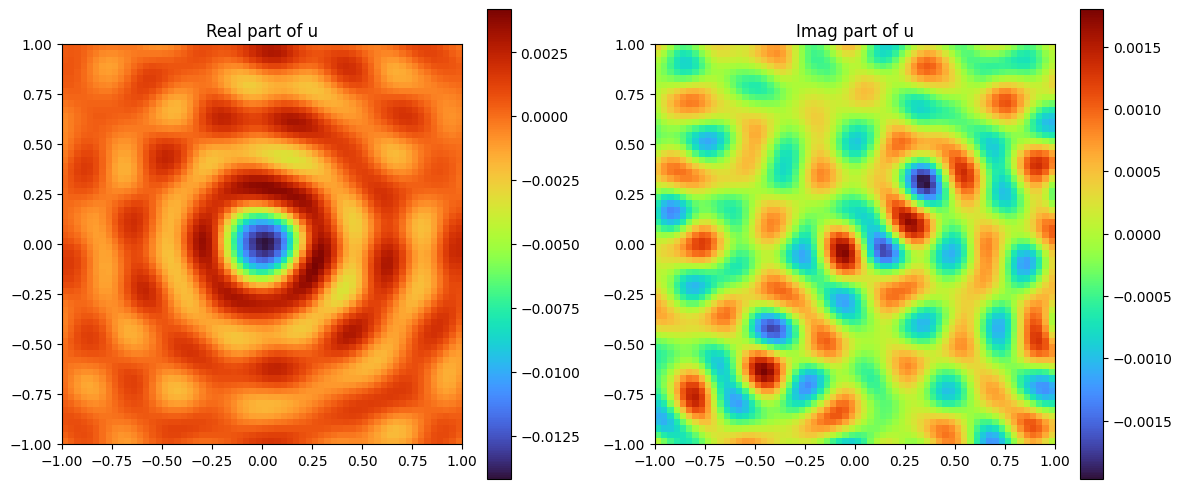

Epoch 3250: Total Loss = 2.812953e-03, PDE Real = 1.889902e-03, PDE Imag = 8.115344e-04, Sommerfeld = 1.115168e-05 
Epoch 3500: Total Loss = 2.508057e-03, PDE Real = 1.684740e-03, PDE Imag = 7.245399e-04, Sommerfeld = 9.877737e-06 
Epoch 3750: Total Loss = 2.232430e-03, PDE Real = 1.498224e-03, PDE Imag = 6.446583e-04, Sommerfeld = 8.954768e-06 
Epoch 4000: Total Loss = 4.799097e-03, PDE Real = 2.256808e-03, PDE Imag = 2.446829e-03, Sommerfeld = 9.545973e-06 


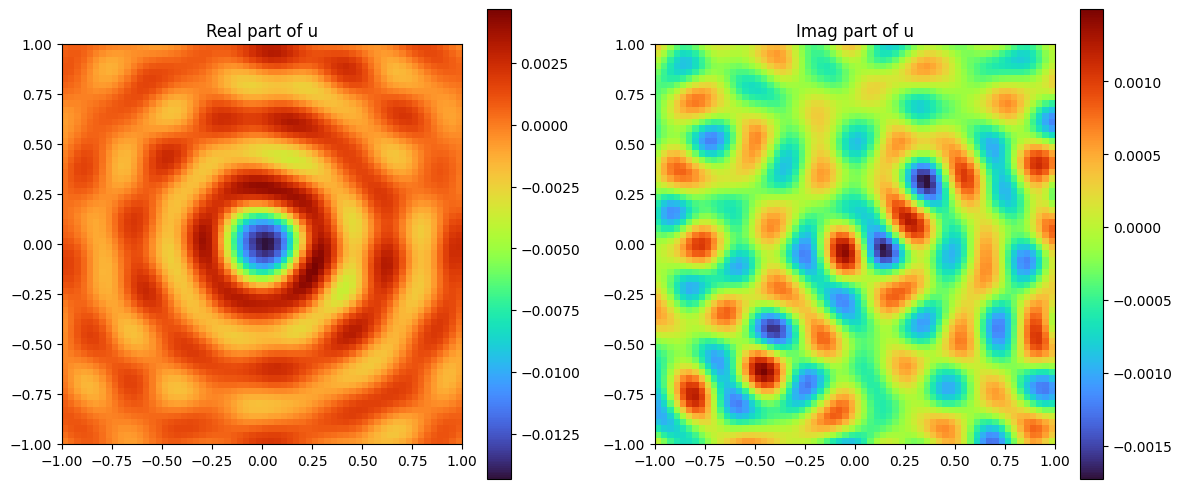

Epoch 4250: Total Loss = 2.133305e-03, PDE Real = 1.366463e-03, PDE Imag = 6.720647e-04, Sommerfeld = 9.477704e-06 
Epoch 4500: Total Loss = 1.970932e-03, PDE Real = 1.332630e-03, PDE Imag = 5.766421e-04, Sommerfeld = 6.166051e-06 
Epoch 4750: Total Loss = 1.840469e-03, PDE Real = 1.202353e-03, PDE Imag = 5.635789e-04, Sommerfeld = 7.453693e-06 
Epoch    0: Total Loss = 1.722430e-03, 


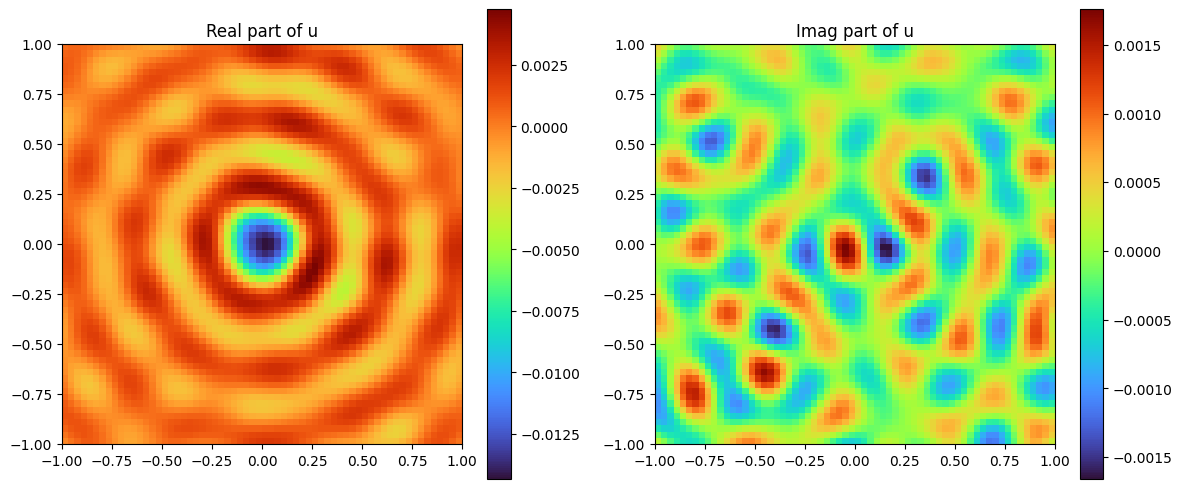

Epoch   10: Total Loss = 1.696332e-03, 
Epoch   20: Total Loss = 1.685285e-03, 


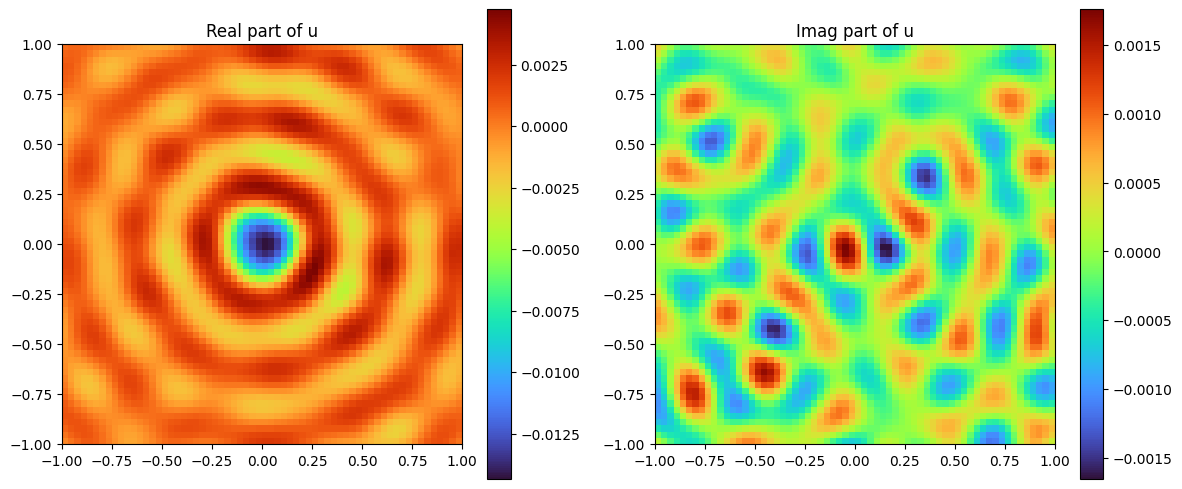

Epoch   30: Total Loss = 1.690157e-03, 
Epoch   40: Total Loss = 1.707632e-03, 


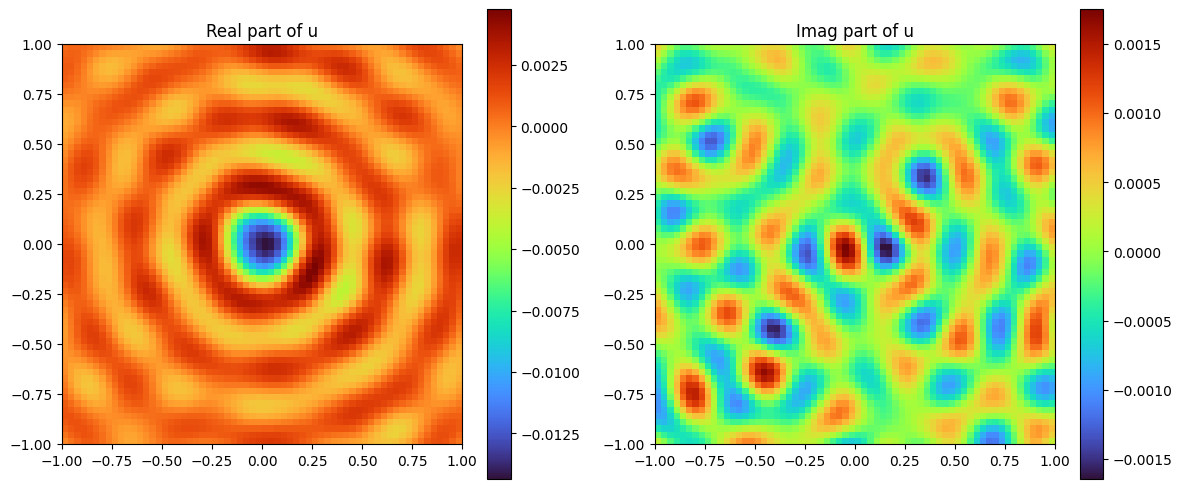

Epoch   50: Total Loss = 1.691163e-03, 
Epoch   60: Total Loss = 1.680496e-03, 


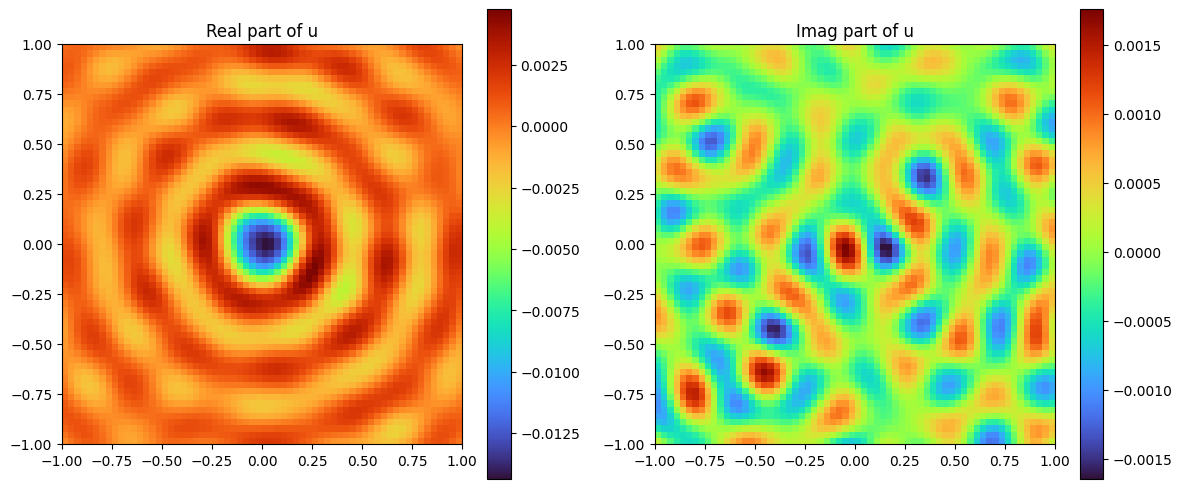

Epoch   70: Total Loss = 1.671991e-03, 
Epoch   80: Total Loss = nan, 


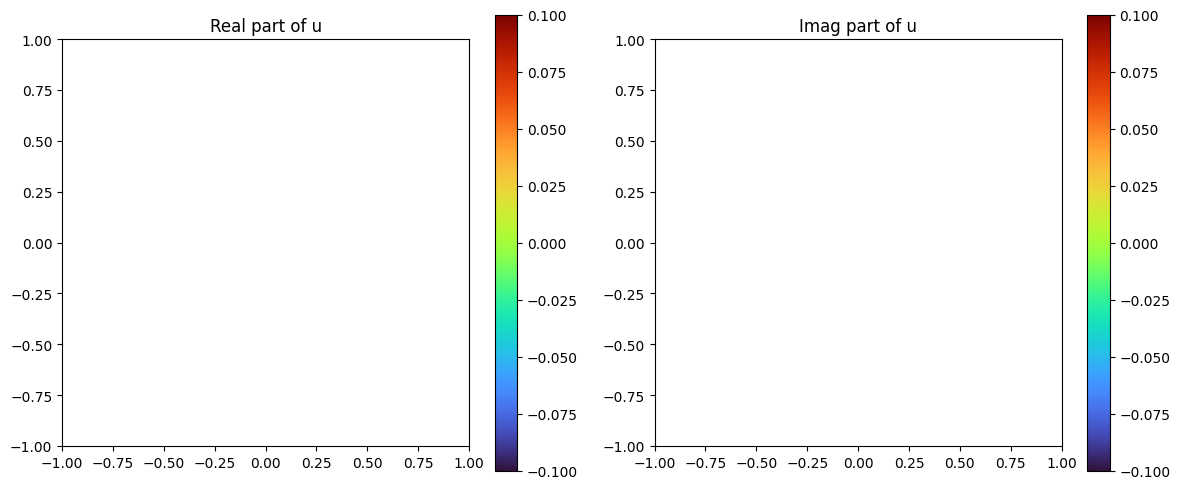

Epoch   90: Total Loss = nan, 


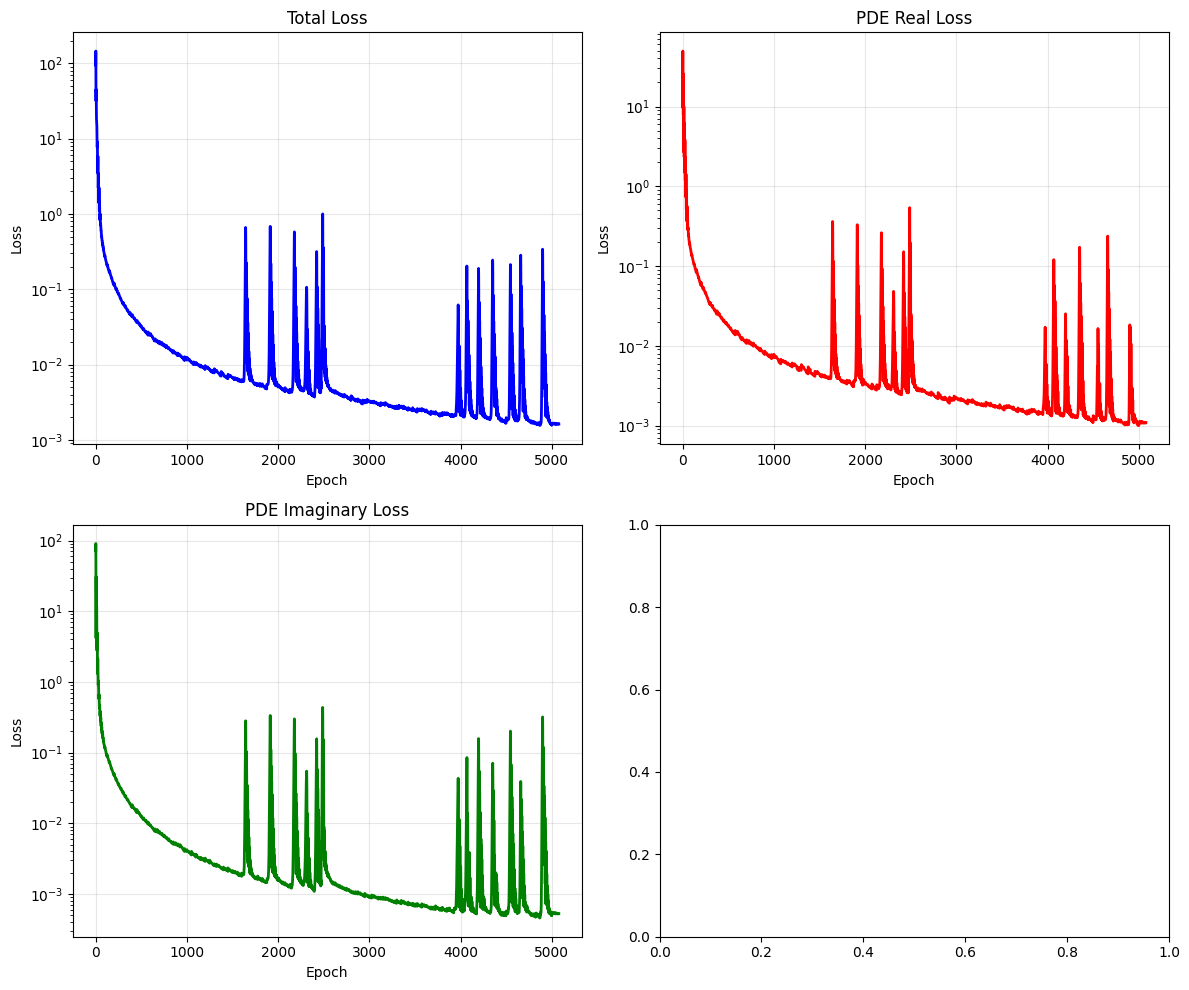

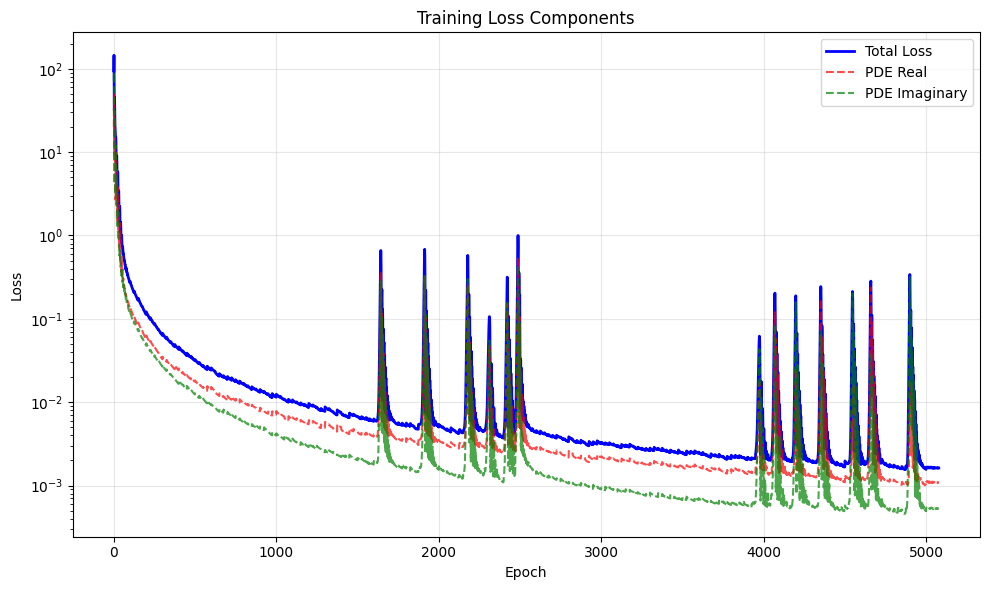

In [ ]:
#Using sommerfeld condition and regular wave equation with random sampling over square

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = Siren(in_features = in_features, hidden_features = hidden_features, hidden_layers = hidden_layers, out_features = out_features).to(device)
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = lr)
trainer = WaveTrainer(model, optimizer, wave_equation, loss_fn, config)
trainer.train()

# We observe that the field is unable to learn imaginary part, leading to divergence in the lasts epochs

Epoch    0: Total Loss = 2.056850e+03, PDE Real = 1.799657e+03, PDE Imag = 1.882945e+02, Sommerfeld = 6.889862e+00 


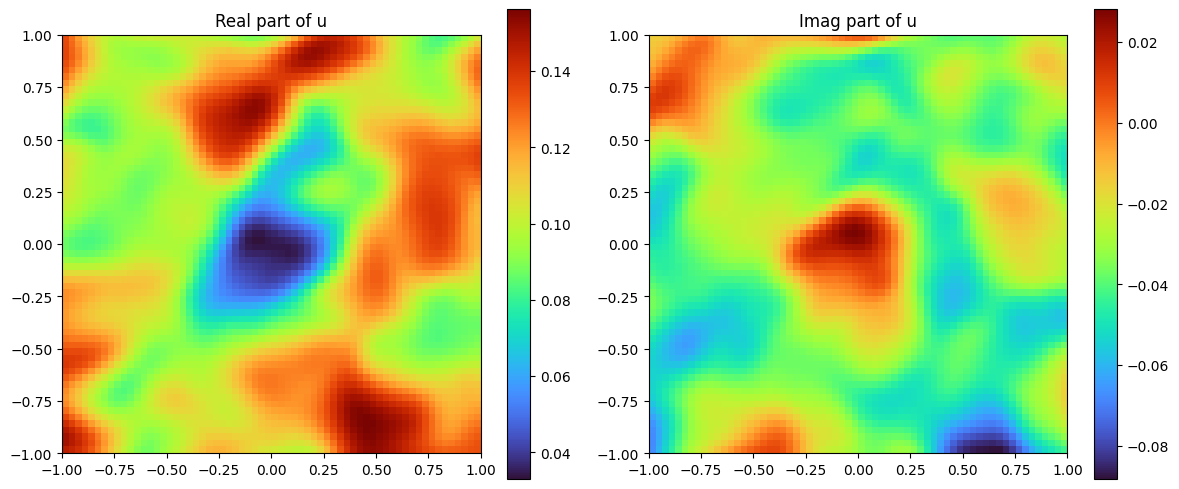

Epoch  250: Total Loss = 6.401778e-02, PDE Real = 1.978321e-02, PDE Imag = 1.828404e-02, Sommerfeld = 2.595053e-03 
Epoch  500: Total Loss = 2.816670e-02, PDE Real = 8.775435e-03, PDE Imag = 1.195509e-02, Sommerfeld = 7.436172e-04 
Epoch  750: Total Loss = 2.957184e-02, PDE Real = 1.296178e-02, PDE Imag = 1.342146e-02, Sommerfeld = 3.188603e-04 
Epoch 1000: Total Loss = 2.288344e-02, PDE Real = 1.028631e-02, PDE Imag = 1.035013e-02, Sommerfeld = 2.246996e-04 


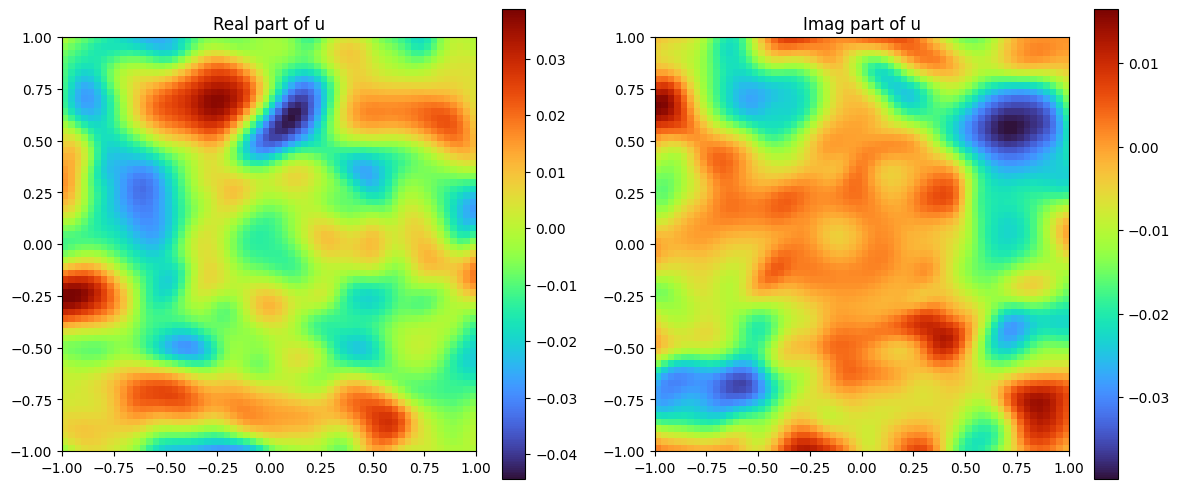

Epoch 1250: Total Loss = 2.191083e-02, PDE Real = 1.238243e-02, PDE Imag = 8.026195e-03, Sommerfeld = 1.502210e-04 
Epoch 1500: Total Loss = 2.834618e-02, PDE Real = 1.756450e-02, PDE Imag = 9.734111e-03, Sommerfeld = 1.047570e-04 
Epoch 1750: Total Loss = 2.933353e-02, PDE Real = 1.990499e-02, PDE Imag = 8.510673e-03, Sommerfeld = 9.178695e-05 
Epoch 2000: Total Loss = 2.059412e-02, PDE Real = 1.154681e-02, PDE Imag = 8.215117e-03, Sommerfeld = 8.321996e-05 


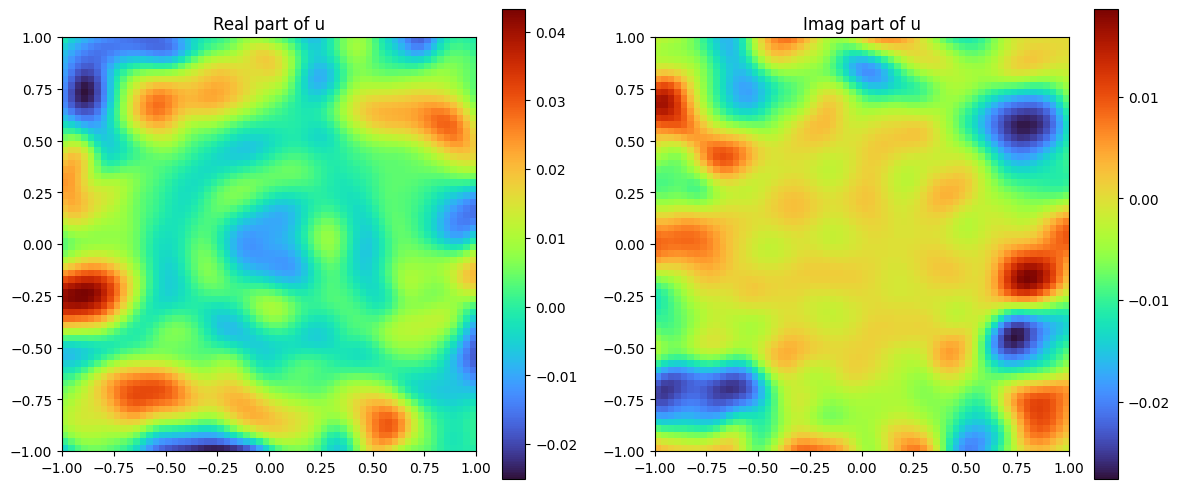

Epoch 2250: Total Loss = 2.287680e-02, PDE Real = 1.385817e-02, PDE Imag = 8.329865e-03, Sommerfeld = 6.887655e-05 
Epoch 2500: Total Loss = 1.657575e-02, PDE Real = 8.031559e-03, PDE Imag = 7.930929e-03, Sommerfeld = 6.132617e-05 
Epoch 2750: Total Loss = 2.139341e-02, PDE Real = 1.182473e-02, PDE Imag = 8.943178e-03, Sommerfeld = 6.255032e-05 
Epoch 3000: Total Loss = 2.327993e-02, PDE Real = 1.418247e-02, PDE Imag = 8.524057e-03, Sommerfeld = 5.734020e-05 


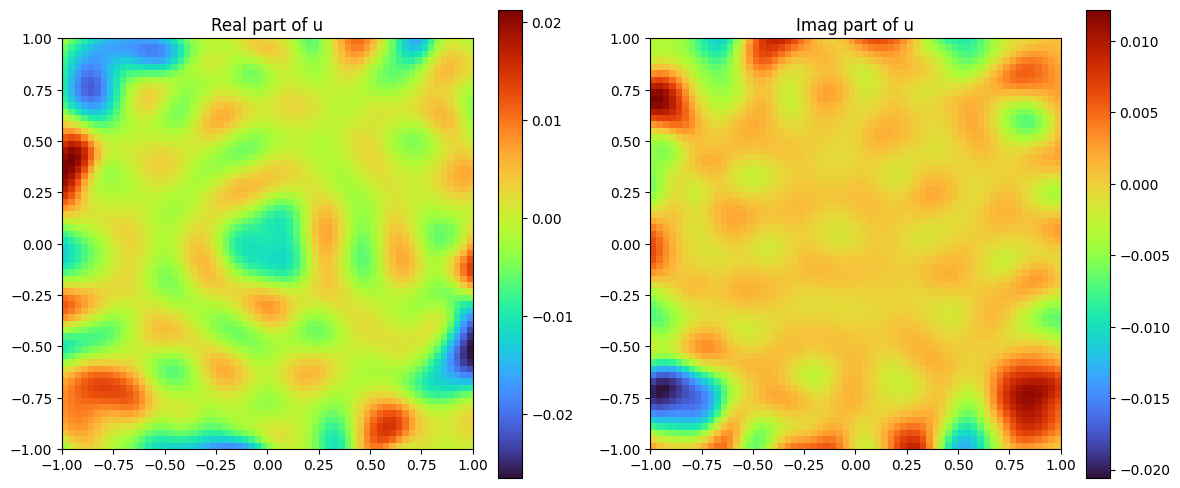

Epoch 3250: Total Loss = 2.493174e-02, PDE Real = 1.617648e-02, PDE Imag = 8.242551e-03, Sommerfeld = 5.127143e-05 
Epoch 3500: Total Loss = 2.225162e-02, PDE Real = 1.253750e-02, PDE Imag = 9.090414e-03, Sommerfeld = 6.237082e-05 
Epoch 3750: Total Loss = 1.906726e-02, PDE Real = 1.195818e-02, PDE Imag = 6.528763e-03, Sommerfeld = 5.803157e-05 
Epoch 4000: Total Loss = 1.746442e-02, PDE Real = 1.091784e-02, PDE Imag = 5.970884e-03, Sommerfeld = 5.756942e-05 


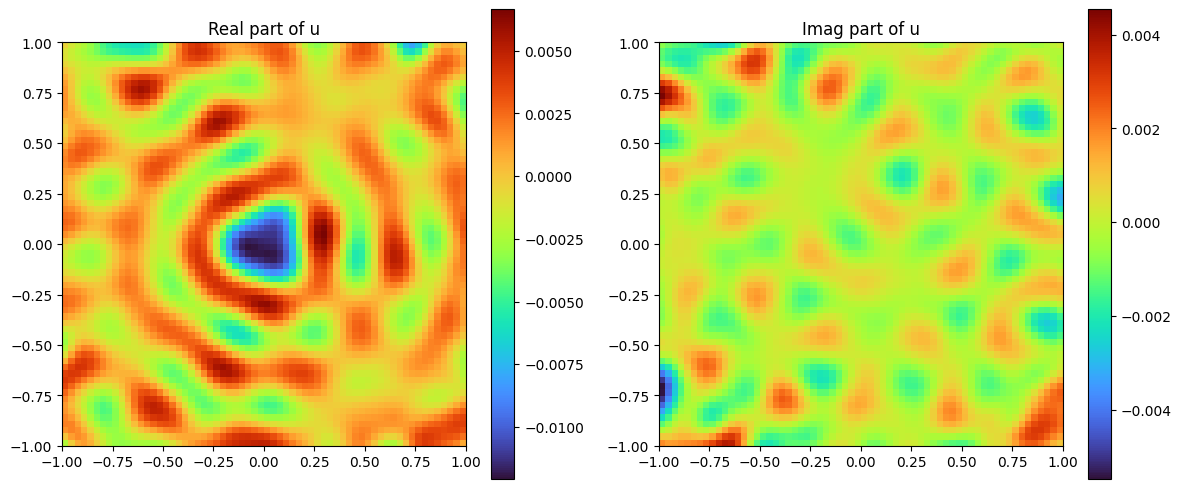

Epoch 4250: Total Loss = 1.947821e-02, PDE Real = 1.380366e-02, PDE Imag = 5.109499e-03, Sommerfeld = 5.650476e-05 
Epoch 4500: Total Loss = 1.177175e-02, PDE Real = 6.927909e-03, PDE Imag = 4.316785e-03, Sommerfeld = 5.270569e-05 
Epoch 4750: Total Loss = 3.715883e-02, PDE Real = 2.913604e-02, PDE Imag = 7.252882e-03, Sommerfeld = 7.699139e-05 
Epoch    0: Total Loss = 1.437088e-01, 


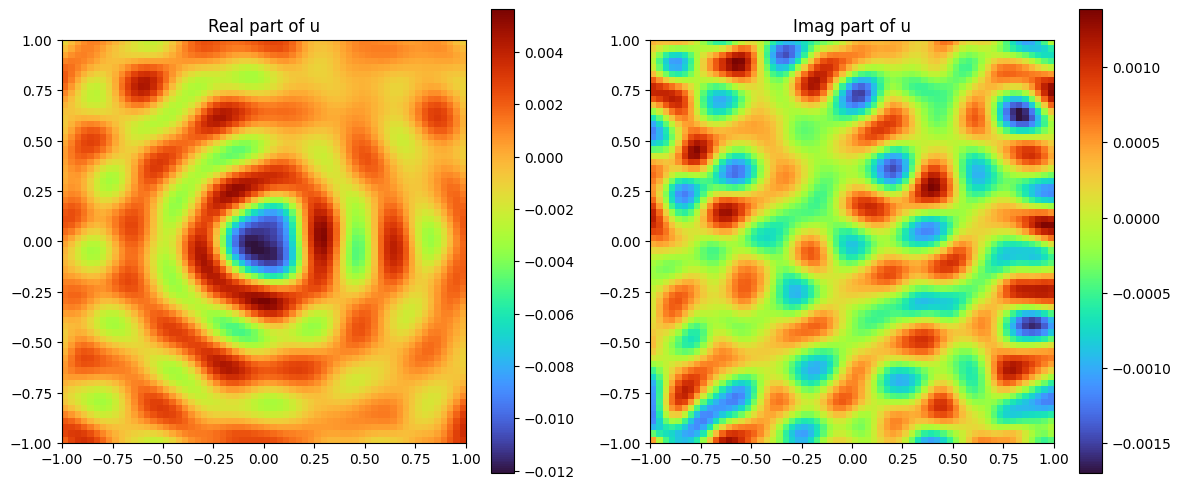

Epoch   10: Total Loss = 3.041091e-02, 
Epoch   20: Total Loss = 2.711099e-02, 


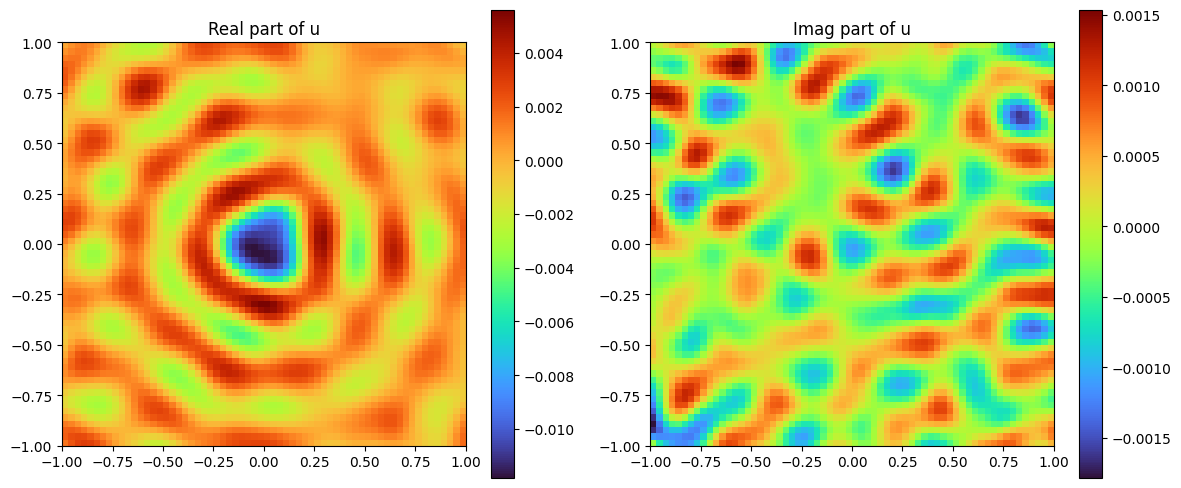

Epoch   30: Total Loss = 2.372139e-02, 
Epoch   40: Total Loss = 2.046923e-02, 


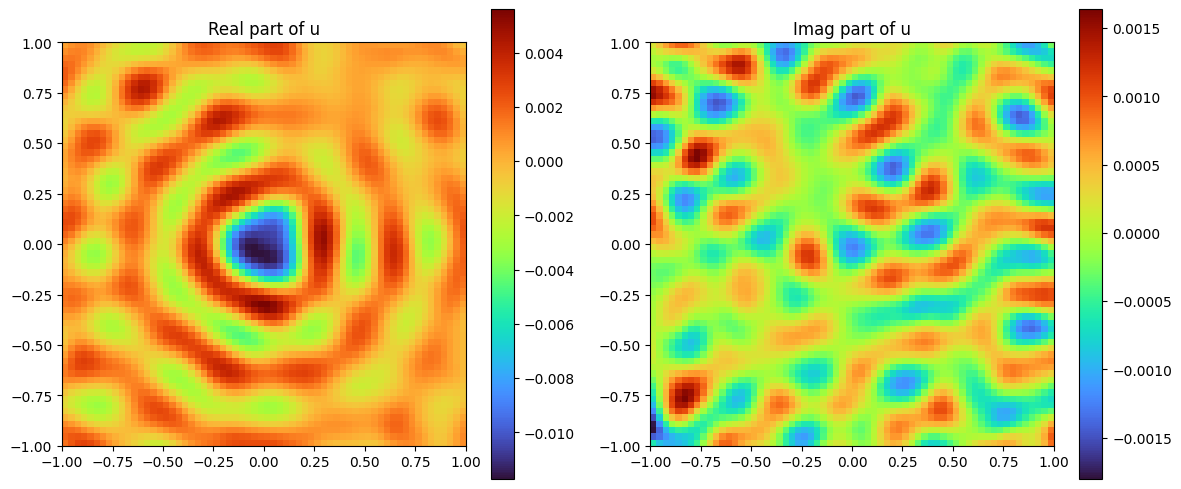

Epoch   50: Total Loss = 1.883878e-02, 
Epoch   60: Total Loss = 1.813461e-02, 


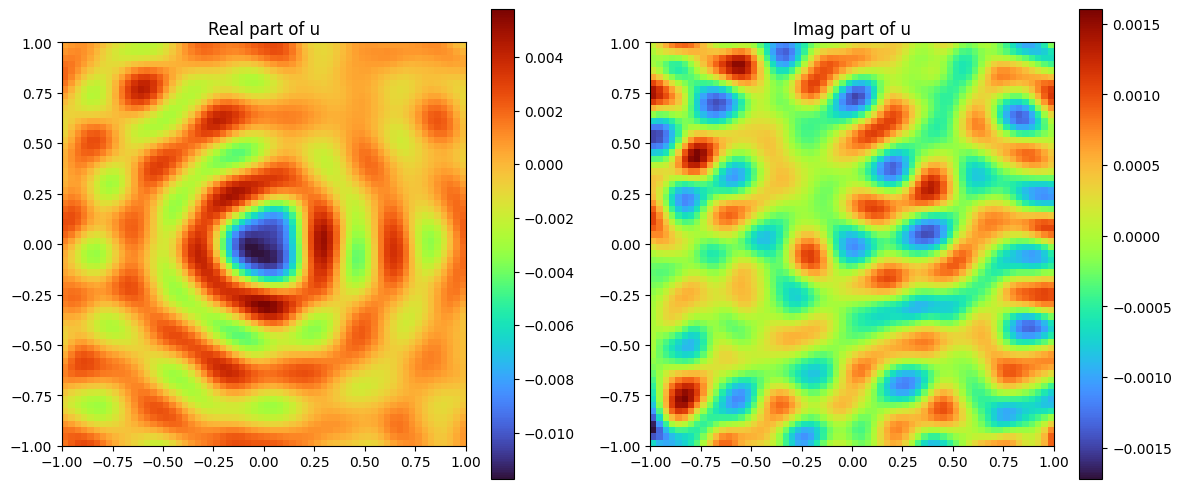

Epoch   70: Total Loss = 1.680188e-02, 
Epoch   80: Total Loss = 1.499823e-02, 


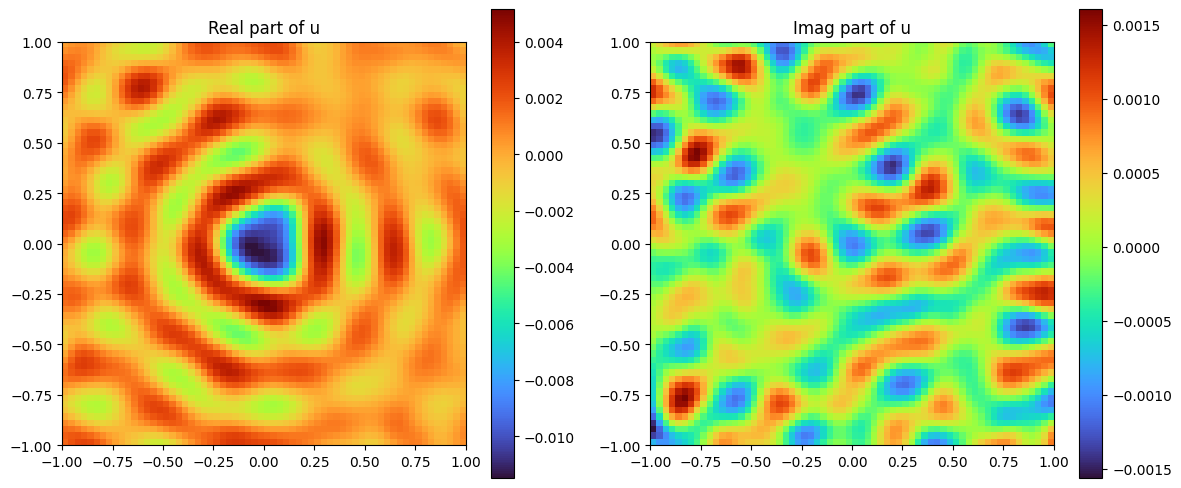

Epoch   90: Total Loss = 1.462361e-02, 


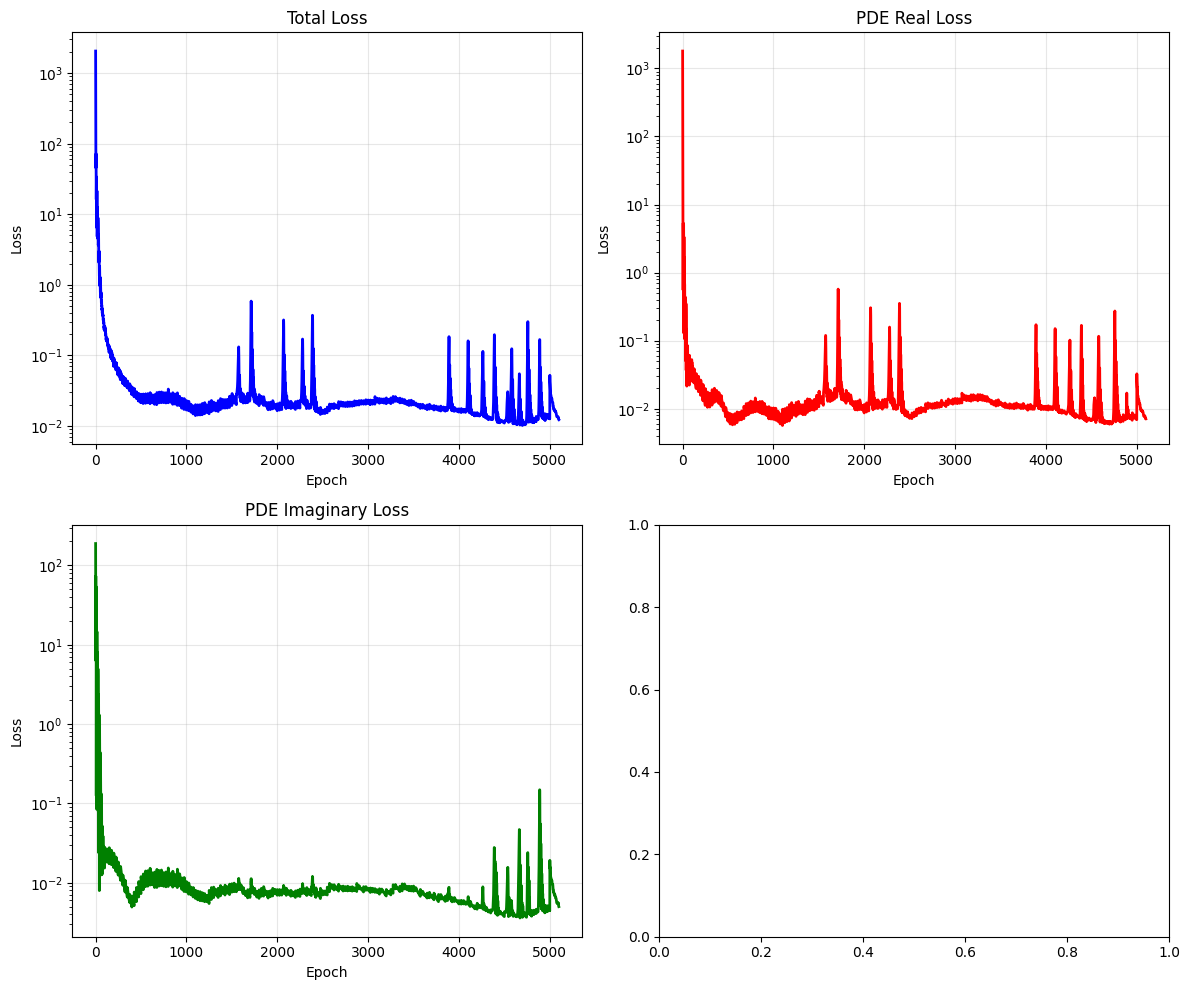

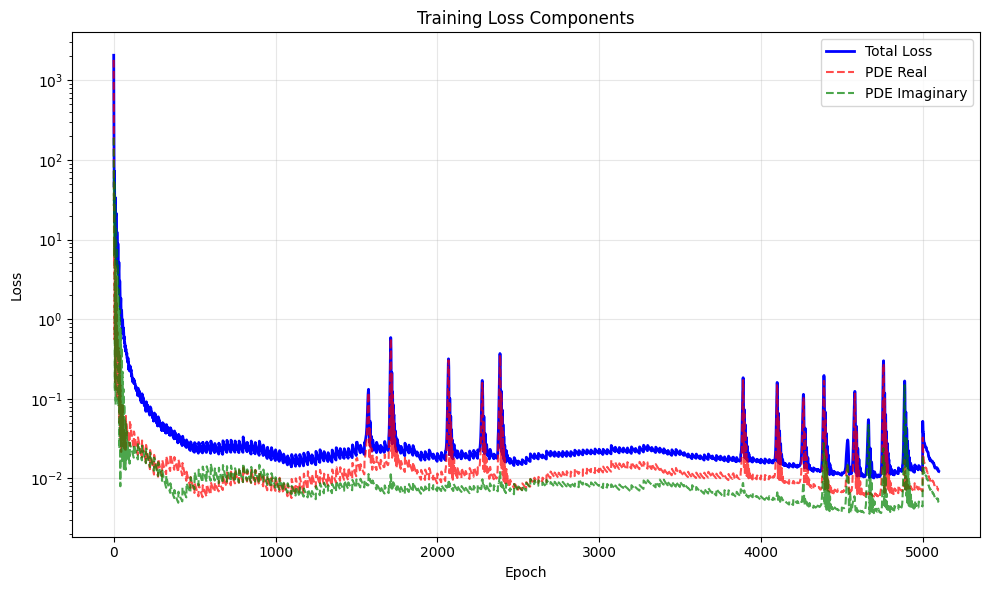

In [ ]:
#Using sommerfeld condition and regular wave equation with circular sampling

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = Siren(in_features = in_features, hidden_features = hidden_features, hidden_layers = hidden_layers, out_features = out_features).to(device)
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = lr)
trainer = WaveTrainer(model, optimizer, wave_equation, loss_fn, config)
trainer.sampling_type = 'circle'
trainer.train()

# We observe that the field is also unable to learn imaginary part and that the produced real fields differ from previous sampling method.
# However the method provided does not diverge as the previous one